# Netflix Shows and Movies - Exploratory Analysis

The dataset consists of meta details about the movies and tv shows such as the title, director, and cast of the shows / movies. Details such as the release year, the rating, duration etc. As the first step, let's load the dataset, create some new features. In this kernel, I have analysed this dataset to find top insights and findings. 

## Dataset Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

# Đọc dữ liệu CSV
df = pd.read_csv("../input/netflix-shows/netflix_titles.csv")
imdb_rating = pd.read_csv("/kaggle/input/netflix-prize-shows-information/imdb.csv")
imdb_rating_processed = pd.read_csv("/kaggle/input/netflix-prize-shows-information/imdb_processed.csv")
netflix_movie = pd.read_csv("/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Movie.csv")
netflix_rating = pd.read_csv("/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv")

# Đọc dữ liệu TSV (sửa lại bằng sep='\t')
netflix_view1 = pd.read_csv(
    "/kaggle/input/netflix-what-we-watched-2023-january-to-june/What_We_Watched_A_Netflix_Engagement_Report_2023Jan-Jun.tsv/What_We_Watched_A_Netflix_Engagement_Report_2023Jan-Jun.tsv",
    sep='\t'
)
netflix_view2_movie = pd.read_csv(
    "/kaggle/input/netflix-what-we-watched-2023-january-to-june/What_We_Watched_A_Netflix_Engagement_Report_2023Jul-Dec/Film.tsv/Film.tsv",
    sep='\t'
)
netflix_view2_tv = pd.read_csv(
    "/kaggle/input/netflix-what-we-watched-2023-january-to-june/What_We_Watched_A_Netflix_Engagement_Report_2023Jul-Dec/TV.tsv/TV.tsv",
    sep='\t'
)

In [2]:
import pandas as pd
import ast

# --------------------------
# Xử lý cột ngày tháng và duration
# --------------------------
df["date_added"] = pd.to_datetime(df['date_added'], errors='coerce')  # thêm errors='coerce' để tránh lỗi
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

df['duration'] = df['duration'].fillna('')
df['season_count'] = df['duration'].apply(lambda x: x.split(" ")[0] if "Season" in x else "")
df['duration'] = df['duration'].apply(lambda x: x.split(" ")[0] if "Season" not in x else "")

df['title'] = df['title'].str.lower()

import pandas as pd
import re

# Các cụm từ cần loại bỏ trong từng genre
remove_keywords = ['TV Shows', 'TV Show', 'TV', 'Shows', 'Show', 'Movies', 'Movie']

# Regex để loại bỏ các từ trên (có thể xuất hiện ở đầu/cuối)
remove_pattern = re.compile(r'\b(?:' + '|'.join(re.escape(k) for k in remove_keywords) + r')\b', re.IGNORECASE)

# Mapping Netflix genre sang IMDb
netflix_to_imdb_genre_map = { 
    'Action & Adventure': ['Action', 'Adventure'],
    'Anime Features': ['Animation'],
    'Anime Series': ['Animation'],
    'Children & Family': ['Family'],
    'Comedies': ['Comedy'],
    'Crime': ['Crime'],
    'Documentaries': ['Documentary'],
    'Docuseries': ['Documentary'],
    'Dramas': ['Drama'],
    'Horror': ['Horror'],
    'Music & Musicals': ['Music', 'Musical'],
    'Mysteries': ['Mystery'],
    'Reality': ['Reality-'],
    'Romantic': ['Romance'],
    'Sci-Fi & Fantasy': ['Sci-Fi', 'Fantasy'],
    'Sports': ['Sport'],
    'Teen': ['Drama', 'Romance'],
    'Thrillers': ['Thriller'],
    # "Kids'": ['Family', 'Animation'],
    # 'LGBTQ': ['Drama', 'Romance'],
    'Science & Nature': ['Documentary'],
    'Stand-Up Comedy': ['Comedy'],
    'Stand-Up Comedy & Talk': ['Comedy', 'Talk-Show'],
}

# Hàm xử lý từng dòng genre
def clean_and_map_genres(genre_str):
    if pd.isna(genre_str):
        return ''
    
    genres = [g.strip() for g in genre_str.split(',')]
    cleaned = []
    
    for g in genres:
        # Loại bỏ từ không mong muốn khỏi genre
        cleaned_g = remove_pattern.sub('', g).strip()
        if not cleaned_g:
            continue
        # Map sang IMDb genres (nếu có), ngược lại giữ nguyên
        mapped = netflix_to_imdb_genre_map.get(cleaned_g, [cleaned_g])
        cleaned.extend(mapped)

    # Loại bỏ trùng lặp, giữ nguyên thứ tự
    seen = set()
    final_genres = [g for g in cleaned if g and g not in seen and not seen.add(g)]
    
    return ', '.join(final_genres)

# Áp dụng vào DataFrame
df['listed_in'] = df['listed_in'].apply(clean_and_map_genres)


# --------------------------
# Xử lý rating
# --------------------------
cols_to_convert = ['genre', 'country', 'language', 'cast', 'director', 'composer', 'writer']

for col in cols_to_convert:
    imdb_rating[col] = imdb_rating[col].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x
    )

kind_mapping = {
    'movie': 'Movie',
    'video movie': 'Movie',
    'tv movie': 'Movie',
    'tv mini series': 'TV Show',
    'tv series': 'TV Show',
    'episode': 'TV Show',
    'tv short': 'TV Show',
    'video game': 'TV Show'
}
imdb_rating['kind'] = imdb_rating['kind'].map(kind_mapping)

imdb_rating_clean = imdb_rating.rename(columns={
    "rating": "imdb_rating",
    "vote": "imdb_vote",
    "kind": "type",
    "genre": "listed_in",
    "runtime": "duration"
})
imdb_rating_clean['title'] = imdb_rating_clean['title'].str.lower()

# Merge rating vào df
# df = df.merge(imdb_rating_clean[['title', 'imdb_rating', 'imdb_vote']], on='title', how='left')

# --------------------------
# Netflix average rating
# --------------------------
rating_avg = netflix_rating.groupby('Movie_ID')['Rating'].mean().reset_index().rename(columns={'Rating': 'netflix_avg_rating'})
movie_info = netflix_movie[['Movie_ID', 'Name']]
movie_rating = pd.merge(movie_info, rating_avg, on='Movie_ID', how='right')

movie_rating = movie_rating.rename(columns={'Name': 'title'})
movie_rating['title'] = movie_rating['title'].str.lower()

# Merge Netflix rating vào df
# df = df.merge(movie_rating[['title', 'netflix_avg_rating']], on='title', how='left')


In [3]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,season_count
0,s1,Movie,dick johnson is dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90,Documentary,"As her father nears the end of his life, filmm...",2021.0,9.0,
1,s2,TV Show,blood & water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,,"International, Drama, Mystery","After crossing paths at a party, a Cape Town t...",2021.0,9.0,2
2,s3,TV Show,ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,,"Crime, International, Action, Adventure",To protect his family from a powerful drug lor...,2021.0,9.0,1
3,s4,TV Show,jailbirds new orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,,"Documentary, Reality-","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,1
4,s5,TV Show,kota factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,,"International, Romance, Comedy",In a city of coaching centers known to train I...,2021.0,9.0,2


In [4]:
rating_merge = imdb_rating_clean.merge(movie_rating[['title', 'netflix_avg_rating']], on='title', how='outer')

In [5]:
rating_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10904 entries, 0 to 10903
Data columns (total 15 columns):
Unnamed: 0            9826 non-null float64
title                 10903 non-null object
year                  9756 non-null float64
type                  9788 non-null object
listed_in             9733 non-null object
imdb_rating           8949 non-null float64
imdb_vote             8949 non-null float64
country               9161 non-null object
language              9033 non-null object
cast                  9482 non-null object
director              7966 non-null object
composer              6204 non-null object
writer                8170 non-null object
duration              8770 non-null float64
netflix_avg_rating    1370 non-null float64
dtypes: float64(6), object(9)
memory usage: 1.3+ MB


In [6]:
correlation = rating_merge['imdb_rating'].corr(rating_merge['netflix_avg_rating'])
print("Correlation between IMDB rating and Netflix average rating:", correlation)

Correlation between IMDB rating and Netflix average rating: 0.6159671273001572


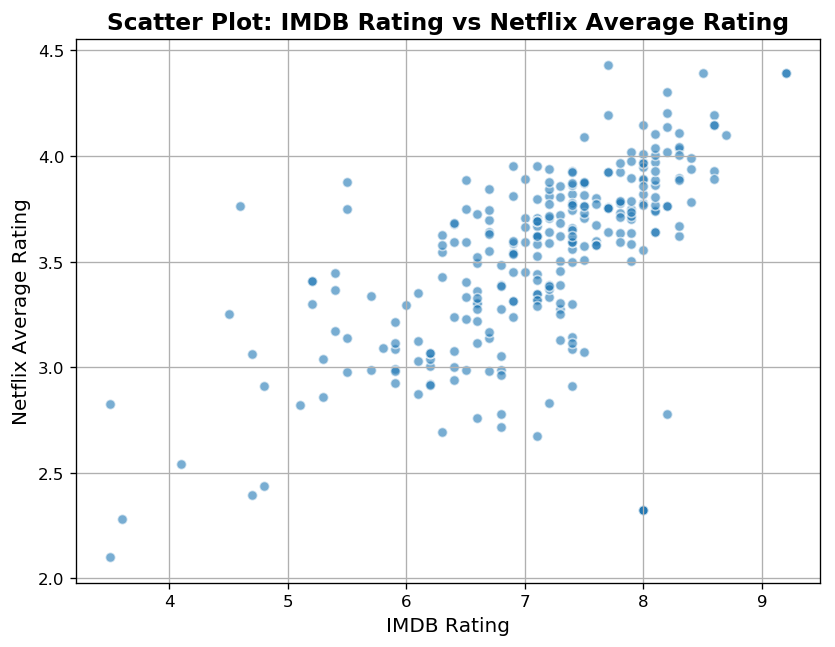

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)
plt.scatter(rating_merge['imdb_rating'], rating_merge['netflix_avg_rating'], alpha=0.6, edgecolors='w')
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Netflix Average Rating', fontsize=12)
plt.title('Scatter Plot: IMDB Rating vs Netflix Average Rating', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()


**Nhận xét:** Có thể thấy, thường những phim có rating IMDb cao thường đồng thời được đánh giá cáo trên Netflix

## 1. Content Type on Netflix 

      type  count
0    Movie   6131
1  TV Show   2676


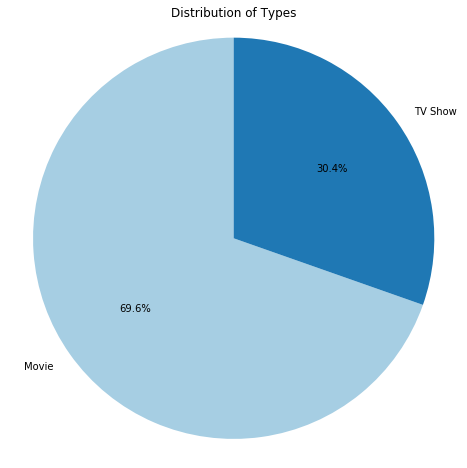

In [8]:
#Biểu đồ tròn Content Type
grouped = df['type'].value_counts().reset_index()
grouped.columns = ['type', 'count']
print(grouped)

plt.figure(figsize=(8, 8))
plt.pie(grouped['count'], labels=grouped['type'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Types')
plt.axis('equal')
plt.show()

- 70%-ish of the content on netflix is movies and remaining 30% of them are TV Shows.

- Số lượng nội dung phim cao gấp 2.3 lần so với số lượng chương trình truyền hình.

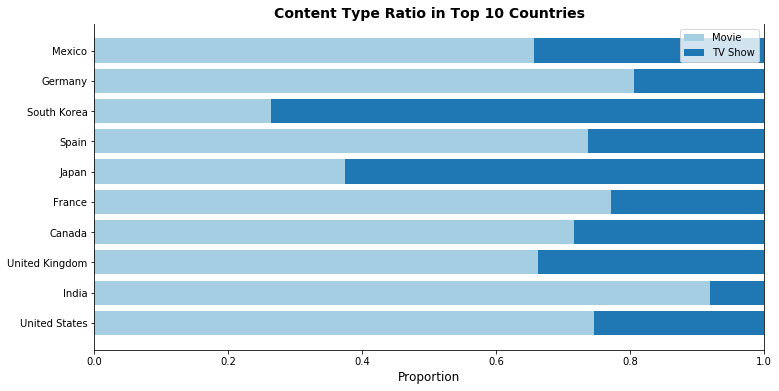

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Tách các quốc gia từ cột country thành nhiều dòng
df_expanded = df.copy()
df_expanded['country'] = df_expanded['country'].str.split(', ')
df_expanded = df_expanded.explode('country')

# Lấy top 10 quốc gia xuất hiện nhiều nhất
country_order = df_expanded['country'].value_counts().head(10).index

# Đếm số lượng Movie và TV Show cho từng quốc gia
data_q2q3 = (
    df_expanded[['type', 'country']]
    .groupby('country')['type']
    .value_counts()
    .unstack()
    .fillna(0)
    .loc[country_order]
)

# Tính tỷ lệ Movie / TV Show
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']]

# Màu sắc từ bảng màu Paired
colors = plt.cm.Paired.colors
movie_color = colors[0]
tvshow_color = colors[1]

# Vẽ biểu đồ stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color=movie_color, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], 
        left=data_q2q3_ratio['Movie'], color=tvshow_color, label='TV Show')

ax.set_xlim(0, 1)
ax.set_xlabel("Proportion", fontsize=12)
ax.set_title("Content Type Ratio in Top 10 Countries", fontsize=14, fontweight='bold')
ax.legend()

# Ẩn trục không cần thiết
ax.spines['top'].set_visible(False)
ax


**Japan và South Korea:**
Tỷ lệ TV Show cao vượt trội so với Movie:
* Ở Japan, hơn 60% nội dung là TV Show, thấp hơn 40% là Movie.
* Ở South Korea, gần như 70% là TV Show, cho thấy một xu hướng mạnh mẽ thiên về nội dung truyền hình.

Điều này phù hợp với thực tế văn hóa và thị trường giải trí tại hai quốc gia này:


* South Korea nổi tiếng toàn cầu với các chương trình truyền hình thực tế, show âm nhạc, drama series, v.v.
* Japan cũng có lượng lớn anime truyền hình, game show, và variety show độc đáo, đóng vai trò trung tâm trong ngành công nghiệp giải trí nước này.


**Các nhận xét khác:**

* United States, India, United Kingdom có tỷ lệ Movie cao hơn hẳn, thể hiện sự đầu tư lớn vào công nghiệp điện ảnh.
* Một số quốc gia như France, Canada, Mexico có tỷ lệ Movie và TV Show gần tương đương nhau, phản ánh sự phát triển tương đối cân bằng giữa hai loại hình nội dung.

**Bài học:** Tuỳ vào thị trường ở từng nước mà chọn loại content type phù hợp để tiếp cận nhiều khán giả hơn.



## 2. Growth in content over the years 

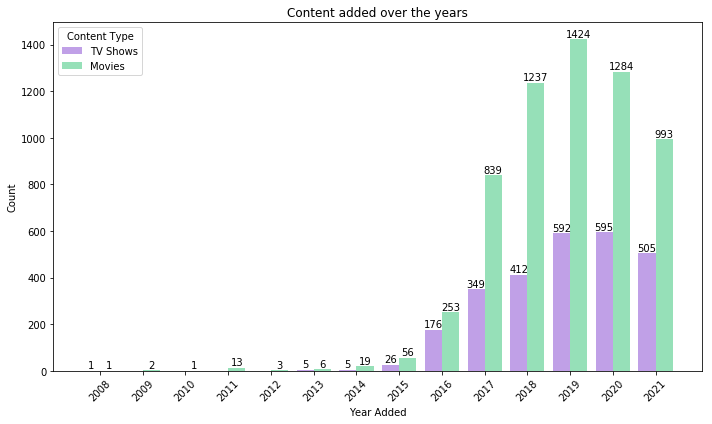

In [10]:
# Lọc dữ liệu cho TV Show và Movie
d1 = df[df["type"] == "TV Show"]
d2 = df[df["type"] == "Movie"]

col = "year_added"

# Tính giá trị cho TV Show
vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns={col: "count", "index": col})
vc1 = vc1.sort_values(col)

# Tính giá trị cho Movie
vc2 = d2[col].value_counts().reset_index()
vc2 = vc2.rename(columns={col: "count", "index": col})
vc2 = vc2.sort_values(col)

years = sorted(set(vc1[col].tolist() + vc2[col].tolist()))

# Tạo DataFrame cho TV Show và Movie, điền giá trị NaN với 0 cho các năm thiếu
vc1_full = pd.DataFrame({col: years})
vc1_full = vc1_full.merge(vc1, on=col, how='left').fillna(0)

vc2_full = pd.DataFrame({col: years})
vc2_full = vc2_full.merge(vc2, on=col, how='left').fillna(0)

# Vẽ biểu đồ cột cho TV Show và Movie
plt.figure(figsize=(10, 6))

# Điều chỉnh khoảng cách giữa các cột TV Show và Movie
width = 0.4

# Vẽ TV Shows và Movie
bars1 = plt.bar(vc1_full[col] - width / 2, vc1_full["count"], width=width, label="TV Shows", color="#a678de", alpha=0.7)
bars2 = plt.bar(vc2_full[col] + width / 2, vc2_full["count"], width=width, label="Movies", color="#6ad49b", alpha=0.7)

# Thêm giá trị lên mỗi thanh trong biểu đồ
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    if yval > 0:  # Chỉ thêm giá trị cho những thanh có giá trị lớn hơn 0
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10)

for i, bar in enumerate(bars2):
    yval = bar.get_height()
    if yval > 0:  # Chỉ thêm giá trị cho những thanh có giá trị lớn hơn 0
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10)

# Thiết lập tiêu đề và nhãn trục
plt.title("Content added over the years")
plt.xlabel("Year Added")
plt.ylabel("Count")
plt.xticks(vc1_full[col], rotation=45)
plt.legend(title="Content Type")

plt.tight_layout()
plt.show()


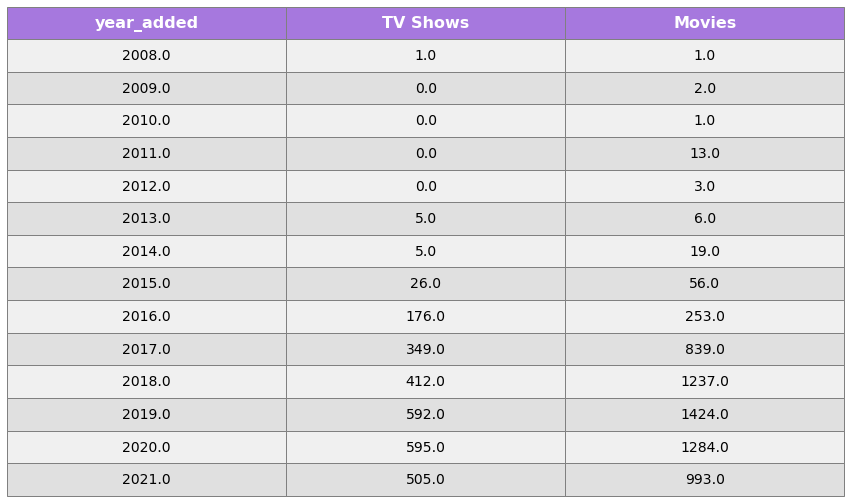

In [11]:
# Dữ liệu dạng bảng
data_table = pd.concat([vc1_full[col], vc1_full["count"], vc2_full["count"]], axis=1)
data_table.columns = [col, "TV Shows", "Movies"]

fig, ax = plt.subplots(figsize=(10, 6))  # Đặt kích thước cho bảng lớn hơn một chút
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data_table.values, colLabels=data_table.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(14)  # Tăng kích thước chữ để dễ đọc hơn
table.scale(1.5, 1.5)  # Điều chỉnh kích thước bảng và chiều cao của mỗi hàng

# Thêm màu
for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#a678de') 
        cell.set_text_props(color='white') 
    else:
        if key[0] % 2 == 0:  # Dòng chẵn
            cell.set_facecolor('#e0e0e0')  
        else:  # Dòng lẻ
            cell.set_facecolor('#f0f0f0')

    cell.set_edgecolor('gray')  
    cell.set_height(0.1) 

plt.show()


### Sự phát triển của Movies và TV Shows trên Netflix:

### Movies:
   Tăng trưởng mạnh mẽ từ 2016, với số lượng phim tăng từ 253 vào 2016 lên hơn 1200 phim trong các năm 2018, 2019, 2020. Movies luôn chiếm ưu thế về số lượng, với sự gia tăng mạnh mẽ qua từng năm, đặc biệt từ 2016 trở đi. Điều này cho thấy Netflix thường chú trọng vào các bộ phim hơn là các chương trình truyền hình.

### TV Shows:
   Sự gia tăng bắt đầu từ 2016, đạt đỉnh vào 2020 với 595 chương trình. Tuy nhiên, mức độ tăng trưởng chưa bằng phim.

### Tỷ lệ phát triển:
   Phim tăng trưởng nhanh hơn TV Shows, với số lượng phim luôn vượt trội qua từng năm. Netflix rõ ràng tập trung mạnh vào việc mở rộng thư viện phim của mình.
### Những yếu tố có thể tác động đến sự phát triển của Movies và TV Shows:

### Sự ảnh hưởng của đại dịch COVID-19:
Năm 2020, cả TV Shows và Movies đều đạt số lượng cao nhất, đặc biệt là phim. Điều này có thể liên quan đến sự thay đổi trong thói quen xem của người dùng trong thời kỳ đại dịch, khi việc xem phim tại nhà trở nên phổ biến hơn và Netflix đã đẩy mạnh sản xuất nội dung để giữ chân người xem.

### Mở rộng quốc tế:
Sự gia tăng đáng kể của nội dung (đặc biệt là phim) từ 2016 có thể phản ánh chiến lược toàn cầu của Netflix. Phim có xu hướng dễ dàng chinh phục khán giả toàn cầu hơn các chương trình truyền hình dài tập, khiến việc đầu tư vào phim có lợi thế cạnh tranh lớn hơn.

### Nhu cầu đa dạng nội dung:
Mặc dù số lượng phim chiếm ưu thế, sự gia tăng mạnh mẽ của TV Shows trong những năm qua cho thấy người xem cũng ngày càng quan tâm đến các chương trình truyền hình với các câu chuyện dài, phong phú và có chiều sâu, điều này thể hiện sự thay đổi trong thói quen giải trí của khán giả.

 
 ## 3. Original Release Year of the movies

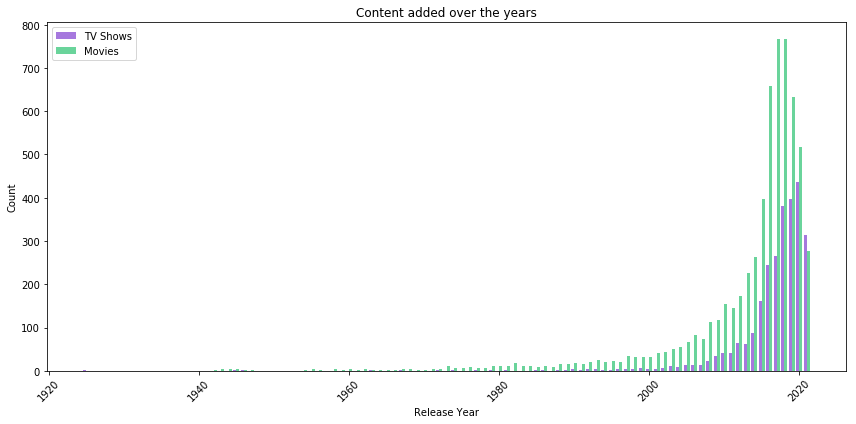

In [12]:
import matplotlib.pyplot as plt

col = "release_year"

# Chuẩn bị dữ liệu cho TV Shows
vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns={col: "count", "index": col})
vc1['percent'] = vc1['count'].apply(lambda x: 100 * x / sum(vc1['count']))
vc1 = vc1.sort_values(col)

# Chuẩn bị dữ liệu cho Movies
vc2 = d2[col].value_counts().reset_index()
vc2 = vc2.rename(columns={col: "count", "index": col})
vc2['percent'] = vc2['count'].apply(lambda x: 100 * x / sum(vc2['count']))
vc2 = vc2.sort_values(col)

# Tạo biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(vc1[col] - 0.2, vc1['count'], width=0.4, label='TV Shows', color="#a678de")
plt.bar(vc2[col] + 0.2, vc2['count'], width=0.4, label='Movies', color="#6ad49b")

plt.title("Content added over the years")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


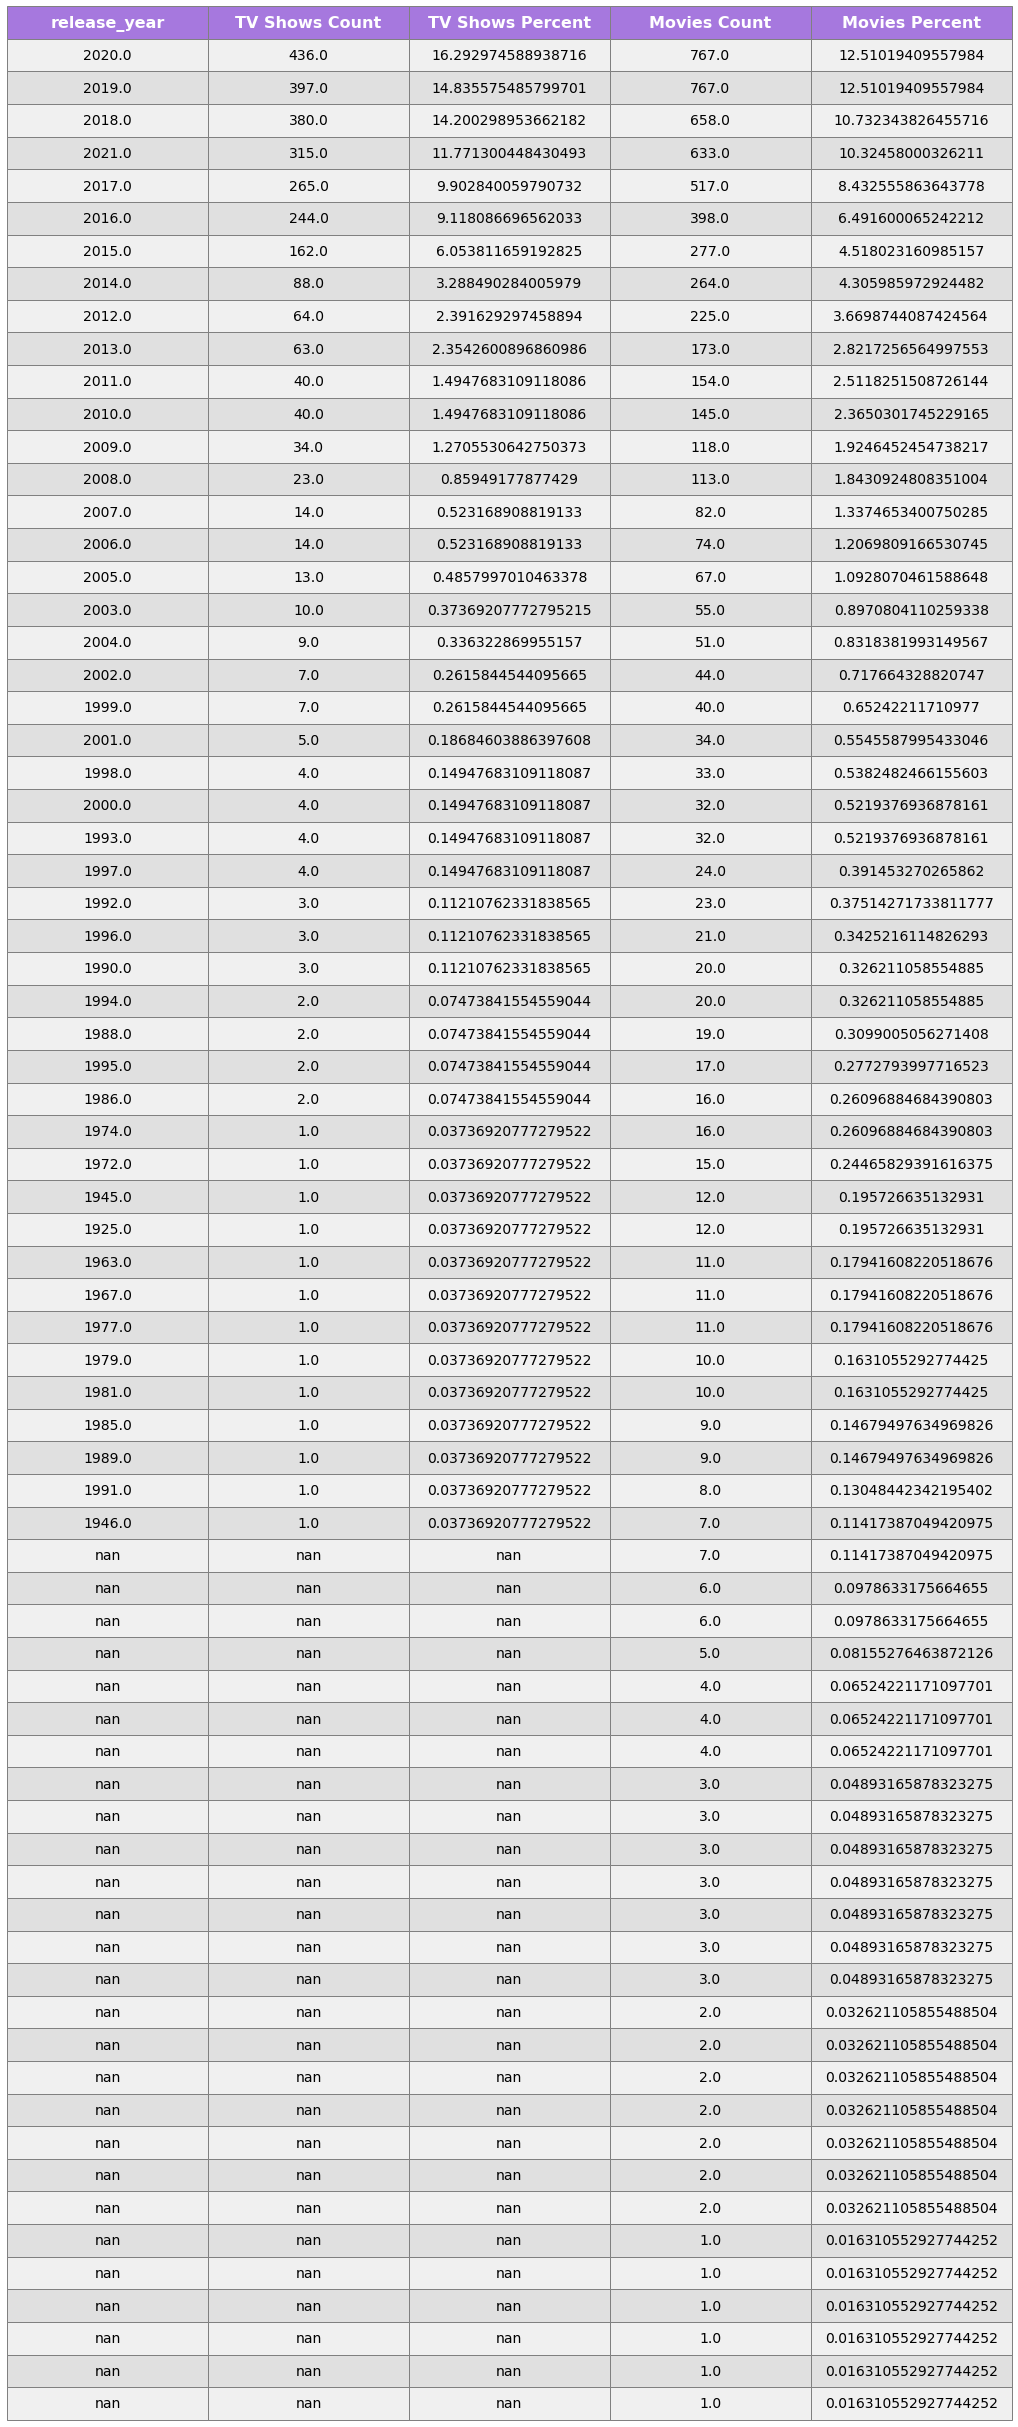

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

col = "release_year"

# Tạo bảng số liệu
data_table = pd.concat([vc1[col], vc1["count"], vc1["percent"], vc2["count"], vc2["percent"]], axis=1)
data_table.columns = [col, "TV Shows Count", "TV Shows Percent", "Movies Count", "Movies Percent"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data_table.values, colLabels=data_table.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(14) 
table.scale(1.5, 1.5)

# Thêm màu
for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#a678de') 
        cell.set_text_props(color='white') 
    else:
        if key[0] % 2 == 0:  # Dòng chẵn
            cell.set_facecolor('#e0e0e0')  
        else:  # Dòng lẻ
            cell.set_facecolor('#f0f0f0')

    cell.set_edgecolor('gray')  
    cell.set_height(0.1) 

plt.show()


## **4. Month added, genre monthly trends**

### **Month added**

    month_added  count   percent
8           1.0   1723  8.208280
11          2.0   1340  6.383688
7           3.0   1775  8.456005
3           4.0   1838  8.756134
10          5.0   1484  7.069697
6           6.0   1786  8.508408
0           7.0   1969  9.380211
2           8.0   1843  8.779953
4           9.0   1832  8.727550
5          10.0   1792  8.536992
9          11.0   1663  7.922443
1          12.0   1946  9.270640


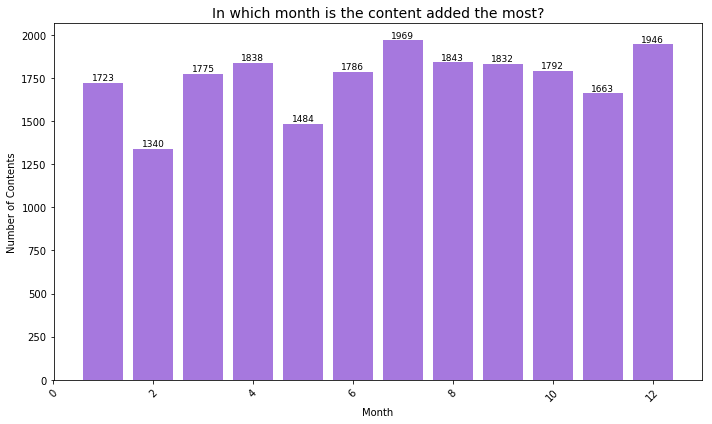

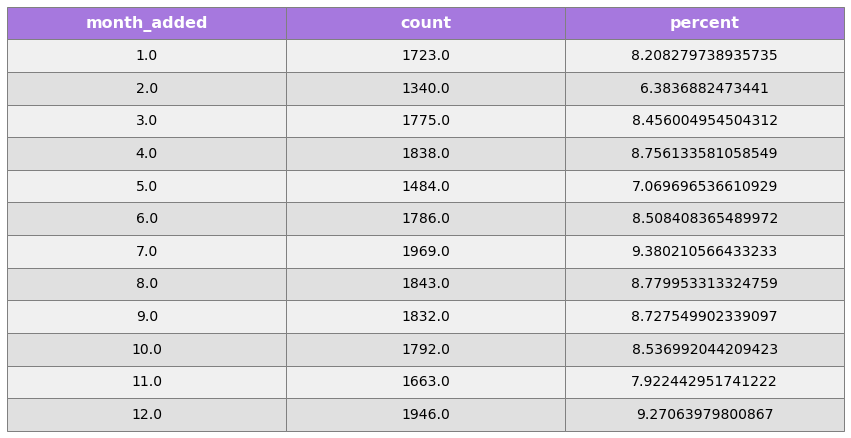

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

col = 'month_added'

# Chuẩn bị dữ liệu
vc1 = df[col].value_counts().reset_index()
vc1 = vc1.rename(columns={col: "count", "index": col})
vc1['percent'] = vc1['count'].apply(lambda x: 100 * x / sum(vc1['count']))
vc1 = vc1.sort_values(col)

# Tạo bảng số liệu
print(vc1)

# Tạo biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(vc1[col], vc1['count'], color="#a678de")

# Thêm số liệu trên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.title("In which month is the content added the most?", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Contents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tạo bảng hiển thị dữ liệu
fig, ax = plt.subplots(figsize=(10, 6))  # Tạo bảng hiển thị dữ liệu

ax.axis('tight')
ax.axis('off')

# Tạo bảng trong biểu đồ
table = ax.table(cellText=vc1.values, colLabels=vc1.columns, cellLoc='center', loc='center')

# Điều chỉnh kích thước bảng
table.auto_set_font_size(False)
table.set_fontsize(14)  # Tăng kích thước chữ
table.scale(1.5, 1.5)  # Điều chỉnh kích thước bảng và chiều cao của mỗi hàng

# Thêm màu cho bảng
for key in table.get_celld().keys():
    cell = table.get_celld()[key]
    if key[0] == 0:  # Dòng tiêu đề
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#a678de')
        cell.set_text_props(color='white')
    else:
        cell.set_facecolor('#f0f0f0' if key[0] % 2 else '#e0e0e0')
    cell.set_edgecolor('gray')
    cell.set_height(0.1)

plt.show()


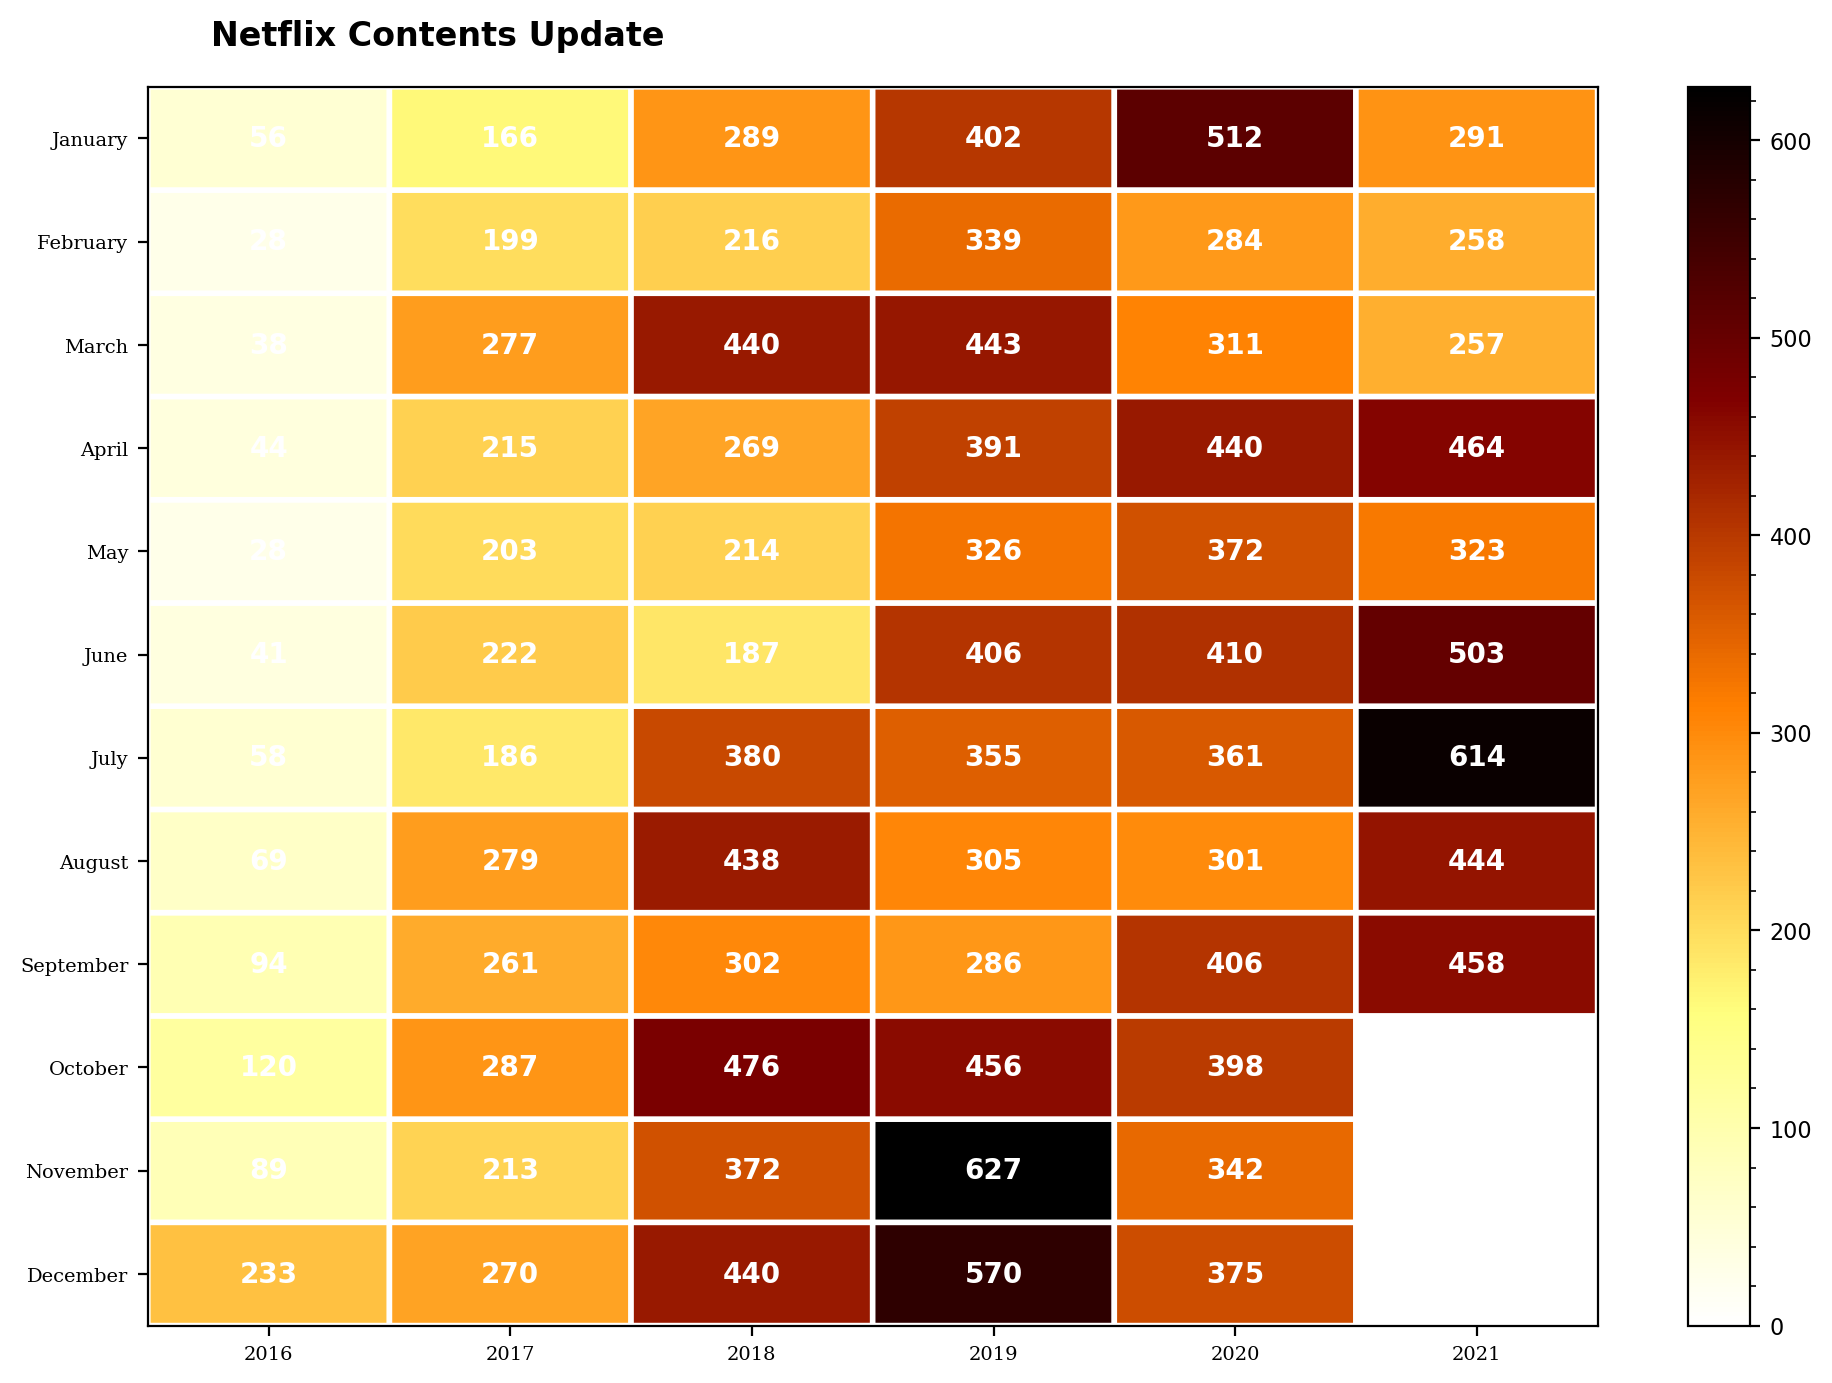

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Lọc dữ liệu và xử lý kiểu
netflix_date = df[['year_added', 'month_added']].dropna().copy()
netflix_date = netflix_date[netflix_date['year_added'] > 2015]
netflix_date['year'] = netflix_date['year_added'].astype(int).astype(str)
netflix_date['month'] = netflix_date['month_added'].astype(int).apply(lambda x: calendar.month_name[x])

# Thứ tự tháng từ December đến January
month_order = list(calendar.month_name[1:])[::-1]

# Tạo ma trận heatmap
heatmap_data = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

# Vẽ heatmap
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(heatmap_data, cmap='afmhot_r', edgecolors='white', linewidths=2)

# Ticks
plt.xticks(np.arange(0.5, len(heatmap_data.columns), 1), heatmap_data.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(heatmap_data.index), 1), heatmap_data.index, fontsize=7, fontfamily='serif')

# Thêm số vào từng ô
for y in range(heatmap_data.shape[0]):
    for x in range(heatmap_data.shape[1]):
        value = int(heatmap_data.iloc[y, x])
        if value > 0:
            plt.text(x + 0.5, y + 0.5, str(value), ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Tiêu đề và colorbar
plt.title('Netflix Contents Update', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0 + 0.02))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()

plt.tight_layout()
plt.show()


1. Netflix ưu tiên thêm nội dung vào các tháng giữa và cuối năm

Các tháng có lượng nội dung được thêm cao nhất là:

- December (12)
- October (10)
- July (7)
- June (6)
- August (8)
- April (4)

Giải thích có thể:
- December & October: Gần với các kỳ nghỉ lớn như Christmas, Thanksgiving, Halloween – là thời điểm người xem dành nhiều thời gian ở nhà → tăng nhu cầu giải trí.
- Summer months (June–August): Kỳ nghỉ hè ở Bắc Mỹ và châu Âu → Netflix tăng nội dung để thu hút người trẻ và gia đình.
- April: Trùng với kỳ nghỉ xuân (spring break) ở Mỹ → phù hợp với chiến dịch khởi động nội dung đầu năm.

2. Các tháng đầu năm (Feb, March) thường có lượng content mới ít hơn

Lượng nội dung vào February (2) và March (3) tuy có tăng nhưng vẫn thấp hơn đáng kể so với các tháng cao điểm như July, October hoặc December.
 
Chiến lược gợi ý: Đây có thể là thời điểm hợp lý để tung các nội dung độc quyền mới hoặc thử nghiệm với thể loại mới vì:
- Ít cạnh tranh hơn.
- Người dùng đang "recover" sau kỳ nghỉ cuối năm, nên dễ chú ý hơn nếu có nội dung nổi bật.
- Phù hợp cho chiến dịch giữ chân người dùng sau mùa hủy đăng ký đầu năm.

3. Tăng trưởng đột biến các năm 2018–2020

Giai đoạn 2018–2020 chứng kiến mức tăng nội dung rõ rệt vào nhiều tháng, đỉnh điểm:
- July 2021 (257 nội dung) – thời điểm phục hồi hậu đại dịch, tăng nội dung để giữ chân người xem.

### **Genre monthly trend**

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Tách thể loại
df['listed_in'] = df['listed_in'].fillna('')
df_exploded = df.copy()
df_exploded['listed_in'] = df_exploded['listed_in'].str.split(', ')
df_exploded = df_exploded.explode('listed_in')

# Chuẩn hoá thể loại: bỏ các từ "Movie", "TV", "TV Show" và strip khoảng trắng
df_exploded['listed_in'] = df_exploded['listed_in'].str.replace(r'\b(Movie|TV|TV Shows|Movies|Shows)\b', '', regex=True)
df_exploded['listed_in'] = df_exploded['listed_in'].str.strip()


# Bước 2: Nhóm theo thể loại và tháng
genre_month_counts = df_exploded.groupby(['listed_in', 'month_added']).size().reset_index(name='count')

# Pivot để tạo bảng cho heatmap
heatmap_data = genre_month_counts.pivot(index='listed_in', columns='month_added', values='count').fillna(0)


In [17]:
unique_genres = df_exploded['listed_in'].str.replace('(?i)(tv show|movie|tv)', '', regex=True).str.strip().unique()
unique_genres = sorted([genre for genre in unique_genres if genre])  # Loại bỏ chuỗi rỗng và sắp xếp

print(unique_genres)

['Action', 'Adventure', 'Animation', 'British', 'Classic', 'Classic & Cult', 'Comedy', 'Crime', 'Cult', 'Documentary', 'Drama', 'Faith & Spirituality', 'Family', 'Fantasy', 'Horror', 'Independent', 'International', "Kids'", 'Korean', 'LGBTQ', 'Music', 'Musical', 'Mystery', 'Reality-', 'Romance', 'Sci-Fi', 'Spanish-Language', 'Sport', 'Talk-Show', 'Thriller']


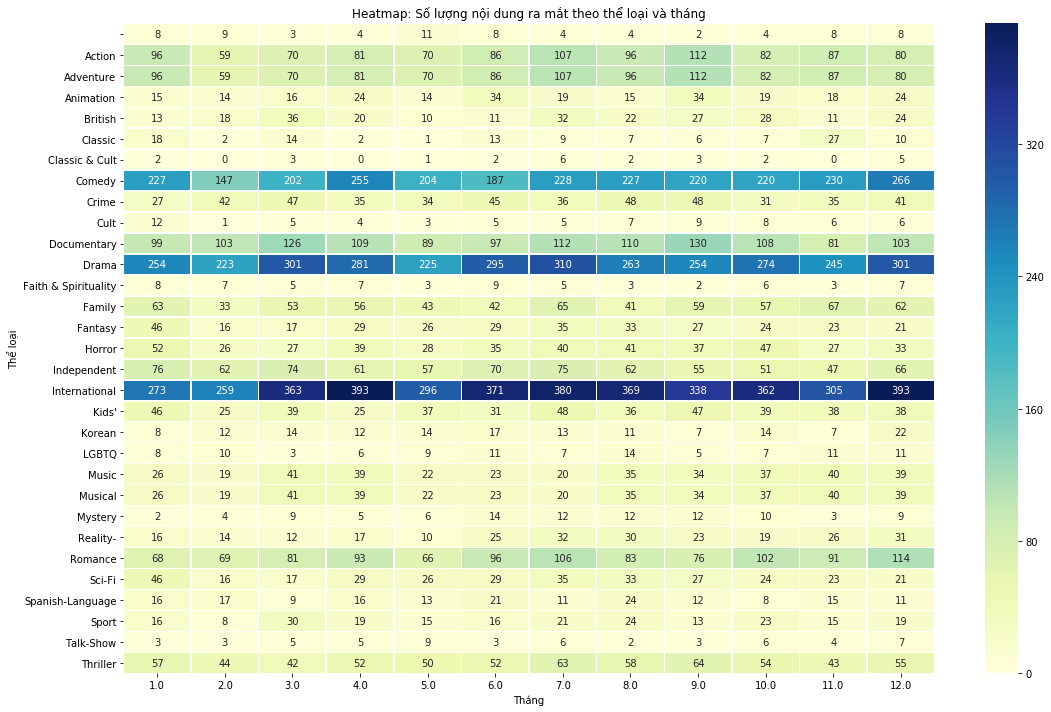

In [18]:
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=True, fmt='.0f')  # Hiển thị số nguyên
plt.title('Heatmap: Số lượng nội dung ra mắt theo thể loại và tháng')
plt.xlabel('Tháng')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()


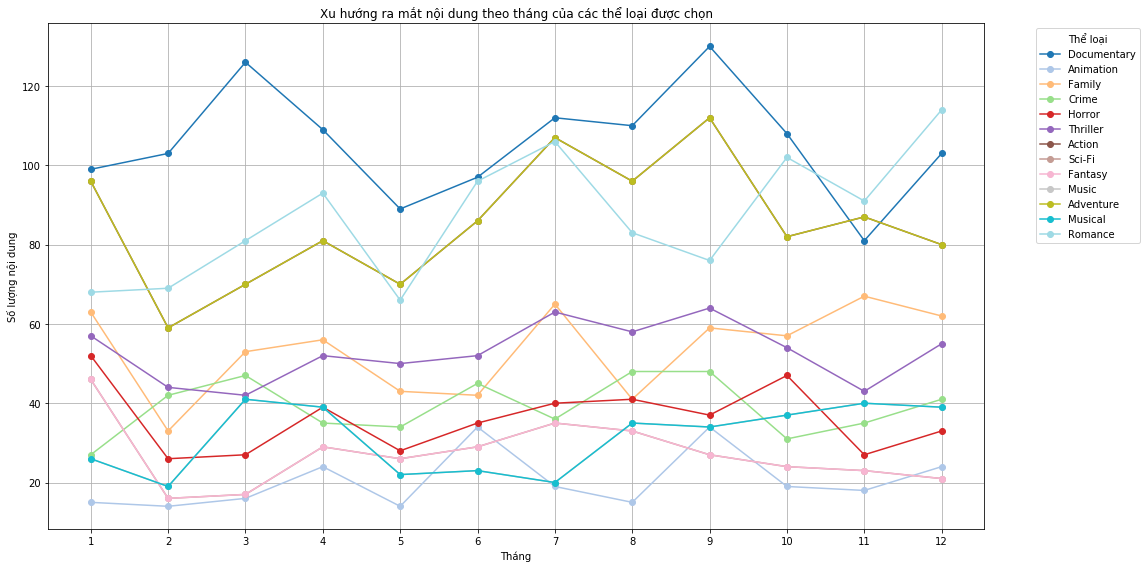

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(16, 8))

# Danh sách thể loại đã chọn
selected_genres = [
    'Documentary', 'Animation', 'Family', 'Crime', 'Horror', 'Thriller', 'Action',
 'Sci-Fi', 'Fantasy', 'Music', 'Adventure', 'Musical', 'Romance'        # Có thể dùng để phân tích sự chuyển dịch theo khu vực hoặc mùa lễ toàn cầu
]


# Gán màu riêng biệt cho từng thể loại
colors = cm.get_cmap('tab20', len(selected_genres))  # tab20 có 20 màu

# Vẽ từng dòng
for idx, genre in enumerate(selected_genres):
    data = genre_month_counts[genre_month_counts['listed_in'] == genre]
    if not data.empty:
        plt.plot(data['month_added'], data['count'], marker='o', label=genre, color=colors(idx))

plt.title('Xu hướng ra mắt nội dung theo tháng của các thể loại được chọn')
plt.xlabel('Tháng')
plt.ylabel('Số lượng nội dung')
plt.legend(title='Thể loại', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


#### 1. Action & Adventure

* Xu hướng cao nhất toàn biểu đồ, nổi bật vào tháng 7 và tháng 9, đạt đỉnh vào tháng 9 (trên 110 nội dung).
* Phù hợp với các phim bom tấn mùa hè – một xu hướng rõ ràng trong ngành công nghiệp giải trí.
#### 2. Romantic

* Biểu đồ khá cao và ổn định, với đỉnh điểm vào tháng 12 (có thể liên quan đến lễ Giáng Sinh và tâm lý cuối năm) v
* Gợi ý rằng phim tình cảm thường ra mắt dịp lễ gắn với cảm xúc, đoàn tụ.
#### 3. Documentaries

* Tương đối ổn định quanh năm, nổi bật hơn vào tháng 3–6, tháng 8, và có một mức cao rõ rệt vào tháng 12.
* Có thể liên quan đến các dịp tổng kết năm hoặc mùa giải thưởng (Oscar, Emmy, v.v.).
#### 4. Horror

* Có một mức tăng nhẹ vào tháng 10, trùng với dịp Halloween.

#### 5. Thrillers

* Dao động nhẹ nhưng cao nhất vào các tháng 8 và 12.
* Gợi ý rằng thể loại này được ưa chuộng dịp cuối hè đến cuối năm.

#### 6. Kids’ & Children & Family

* Có xu hướng tăng vào tháng 6–8, rõ ràng phù hợp với kỳ nghỉ hè.
* Cũng tăng nhẹ vào tháng 12 (Giáng Sinh, mùa quà tặng cho trẻ em).






##### Some of the oldest movies on Netflix

In [20]:
small = df.sort_values("release_year", ascending = True)
small = small[small['duration'] != ""]
small[['title', "release_year"]][:15]

,title,release_year
7790,prelude to war,1942
8205,the battle of midway,1942
8660,undercover: how to operate behind enemy lines,1943
8739,why we fight: the battle of russia,1943
8763,wwii: report from the aleutians,1943
8640,tunisian victory,1944
8436,the negro soldier,1944
8419,the memphis belle: a story of a\nflying fortress,1944
7930,san pietro,1945
7219,know your enemy - japan,1945


Some of the oldest TV Shows on Netflix

In [21]:
small = df.sort_values("release_year", ascending = True)
small = small[small['season_count'] != ""]
small[['title', "release_year"]][:15]

,title,release_year
4250,pioneers: first women filmmakers*,1925
1331,five came back: the reference films,1945
7743,pioneers of african-american cinema,1946
8541,the twilight zone (original series),1963
8189,the andy griffith show,1967
4550,monty python's fliegender zirkus,1972
4551,monty python's flying circus,1974
6549,dad's army,1977
6674,el chavo,1979
7588,ninja hattori,1981


There are movies / shows on the platform which were released way back in 1930s and 40s. 

## 5. Content from different Countries

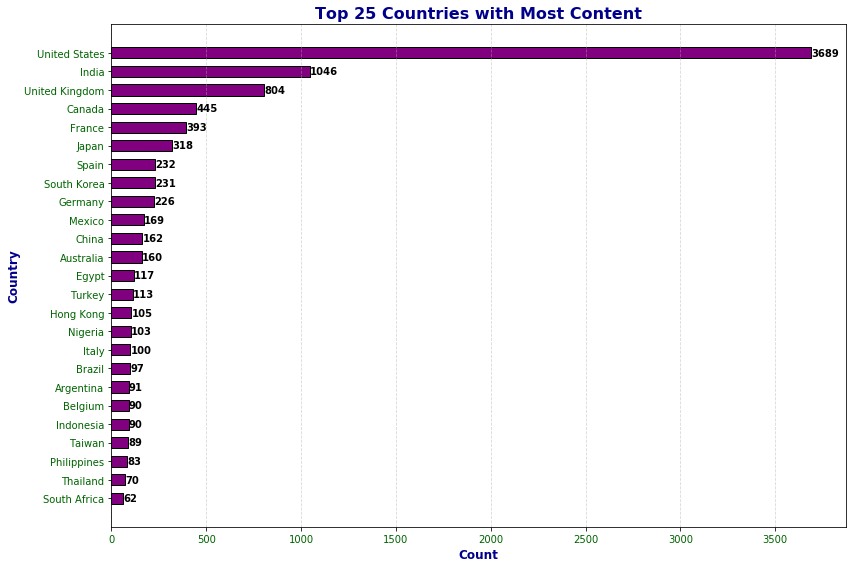

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Mã các quốc gia
country_codes = {
    'afghanistan': 'AFG', 'albania': 'ALB', 'algeria': 'DZA', 'american samoa': 'ASM', 'andorra': 'AND',
    'angola': 'AGO', 'anguilla': 'AIA', 'antigua and barbuda': 'ATG', 'argentina': 'ARG', 'armenia': 'ARM',
    'aruba': 'ABW', 'australia': 'AUS', 'austria': 'AUT', 'azerbaijan': 'AZE', 'bahamas': 'BHM', 'bahrain': 'BHR',
    'bangladesh': 'BGD', 'barbados': 'BRB', 'belarus': 'BLR', 'belgium': 'BEL', 'belize': 'BLZ', 'benin': 'BEN',
    'bermuda': 'BMU', 'bhutan': 'BTN', 'bolivia': 'BOL', 'bosnia and herzegovina': 'BIH', 'botswana': 'BWA',
    'brazil': 'BRA', 'british virgin islands': 'VGB', 'brunei': 'BRN', 'bulgaria': 'BGR', 'burkina faso': 'BFA',
    'burma': 'MMR', 'burundi': 'BDI', 'cabo verde': 'CPV', 'cambodia': 'KHM', 'cameroon': 'CMR', 'canada': 'CAN',
    'cayman islands': 'CYM', 'central african republic': 'CAF', 'chad': 'TCD', 'chile': 'CHL', 'china': 'CHN',
    'colombia': 'COL', 'comoros': 'COM', 'congo democratic': 'COD', 'Congo republic': 'COG', 'cook islands': 'COK',
    'costa rica': 'CRI', "cote d'ivoire": 'CIV', 'croatia': 'HRV', 'cuba': 'CUB', 'curacao': 'CUW', 'cyprus': 'CYP',
    'czech republic': 'CZE', 'denmark': 'DNK', 'djibouti': 'DJI', 'dominica': 'DMA', 'dominican republic': 'DOM',
    'ecuador': 'ECU', 'egypt': 'EGY', 'el salvador': 'SLV', 'equatorial guinea': 'GNQ', 'eritrea': 'ERI', 'estonia': 'EST',
    'ethiopia': 'ETH', 'falkland islands': 'FLK', 'faroe islands': 'FRO', 'fiji': 'FJI', 'finland': 'FIN', 'france': 'FRA',
    'french polynesia': 'PYF', 'gabon': 'GAB', 'gambia, the': 'GMB', 'georgia': 'GEO', 'germany': 'DEU', 'ghana': 'GHA',
    'gibraltar': 'GIB', 'greece': 'GRC', 'greenland': 'GRL', 'grenada': 'GRD', 'guam': 'GUM', 'guatemala': 'GTM',
    'guernsey': 'GGY', 'guinea-bissau': 'GNB', 'guinea': 'GIN', 'guyana': 'GUY', 'haiti': 'HTI', 'honduras': 'HND',
    'hong kong': 'HKG', 'hungary': 'HUN', 'iceland': 'ISL', 'india': 'IND', 'indonesia': 'IDN', 'iran': 'IRN', 'iraq': 'IRQ',
    'ireland': 'IRL', 'isle of man': 'IMN', 'israel': 'ISR', 'italy': 'ITA', 'jamaica': 'JAM', 'japan': 'JPN',
    'jersey': 'JEY', 'jordan': 'JOR', 'kazakhstan': 'KAZ', 'kenya': 'KEN', 'kiribati': 'KIR', 'north korea': 'PRK',
    'south korea': 'KOR', 'kosovo': 'KSV', 'kuwait': 'KWT', 'kyrgyzstan': 'KGZ', 'laos': 'LAO', 'latvia': 'LVA',
    'lebanon': 'LBN', 'lesotho': 'LSO', 'liberia': 'LBR', 'libya': 'LBY', 'liechtenstein': 'LIE', 'lithuania': 'LTU',
    'luxembourg': 'LUX', 'macau': 'MAC', 'macedonia': 'MKD', 'madagascar': 'MDG', 'malawi': 'MWI', 'malaysia': 'MYS',
    'maldives': 'MDV', 'mali': 'MLI', 'malta': 'MLT', 'marshall islands': 'MHL', 'mauritania': 'MRT', 'mauritius': 'MUS',
    'mexico': 'MEX', 'micronesia': 'FSM', 'moldova': 'MDA', 'monaco': 'MCO', 'mongolia': 'MNG', 'montenegro': 'MNE',
    'morocco': 'MAR', 'mozambique': 'MOZ', 'namibia': 'NAM', 'nepal': 'NPL', 'netherlands': 'NLD', 'new caledonia': 'NCL',
    'new zealand': 'NZL', 'nicaragua': 'NIC', 'nigeria': 'NGA', 'niger': 'NER', 'niue': 'NIU', 'northern mariana islands': 'MNP',
    'norway': 'NOR', 'oman': 'OMN', 'pakistan': 'PAK', 'palau': 'PLW', 'panama': 'PAN', 'papua new guinea': 'PNG',
    'paraguay': 'PRY', 'peru': 'PER', 'philippines': 'PHL', 'poland': 'POL', 'portugal': 'PRT', 'puerto rico': 'PRI',
    'qatar': 'QAT', 'romania': 'ROU', 'russia': 'RUS', 'rwanda': 'RWA', 'saint kitts and nevis': 'KNA', 'saint lucia': 'LCA',
    'saint martin': 'MAF', 'saint pierre and miquelon': 'SPM', 'saint vincent and the grenadines': 'VCT', 'samoa': 'WSM',
    'san marino': 'SMR', 'sao tome and principe': 'STP', 'saudi arabia': 'SAU', 'senegal': 'SEN', 'serbia': 'SRB',
    'seychelles': 'SYC', 'sierra leone': 'SLE', 'singapore': 'SGP', 'sint maarten': 'SXM', 'slovakia': 'SVK', 'slovenia': 'SVN',
    'solomon islands': 'SLB', 'somalia': 'SOM', 'south africa': 'ZAF', 'south sudan': 'SSD', 'spain': 'ESP', 'sri lanka': 'LKA',
    'sudan': 'SDN', 'suriname': 'SUR', 'swaziland': 'SWZ', 'sweden': 'SWE', 'switzerland': 'CHE', 'syria': 'SYR',
    'taiwan': 'TWN', 'tajikistan': 'TJK', 'tanzania': 'TZA', 'thailand': 'THA', 'timor-leste': 'TLS', 'togo': 'TGO',
    'tonga': 'TON', 'trinidad and tobago': 'TTO', 'tunisia': 'TUN', 'turkey': 'TUR', 'turkmenistan': 'TKM',
    'tuvalu': 'TUV', 'uganda': 'UGA', 'ukraine': 'UKR', 'united arab emirates': 'ARE', 'united kingdom': 'GBR',
    'united states': 'USA', 'uruguay': 'URY', 'uzbekistan': 'UZB', 'vanuatu': 'VUT', 'venezuela': 'VEN', 'vietnam': 'VNM',
    'virgin islands': 'VGB', 'west bank': 'WBG', 'yemen': 'YEM', 'zambia': 'ZMB', 'zimbabwe': 'ZWE'
}

def geoplot(ddf):
    country_with_code, country = {}, {}
    shows_countries = ", ".join(ddf['country'].dropna()).split(", ")
    for c,v in dict(Counter(shows_countries)).items():
        code = ""
        if c.lower() in country_codes:
            code = country_codes[c.lower()]
        country_with_code[code] = v
        country[c] = v
    
    return country

country_vals = geoplot(df)
tabs = Counter(country_vals).most_common(25)


labels = [_[0] for _ in tabs][::-1]
values = [_[1] for _ in tabs][::-1]

plt.figure(figsize=(12, 8))

bars = plt.barh(labels, values, color="purple", edgecolor='black', height=0.6)

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', 
             va='center', ha='left', fontsize=10, fontweight='bold', color='black')

plt.title("Top 25 Countries with Most Content", fontsize=16, fontweight='bold', color="darkblue")
plt.xlabel("Count", fontsize=12, fontweight='bold', color="darkblue")
plt.ylabel("Country", fontsize=12, fontweight='bold', color="darkblue")

plt.xticks(fontsize=10, color='darkgreen')
plt.yticks(fontsize=10, color='darkgreen')

plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [23]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from collections import Counter

init_notebook_mode(connected=True)

country_codes = {'afghanistan': 'AFG', 'albania': 'ALB', 'algeria': 'DZA', 'american samoa': 'ASM', 'andorra': 'AND',
                 'angola': 'AGO', 'anguilla': 'AIA', 'antigua and barbuda': 'ATG', 'argentina': 'ARG', 'armenia': 'ARM',
                 'aruba': 'ABW', 'australia': 'AUS', 'austria': 'AUT', 'azerbaijan': 'AZE', 'bahamas': 'BHM',
                 'bahrain': 'BHR', 'bangladesh': 'BGD', 'barbados': 'BRB', 'belarus': 'BLR', 'belgium': 'BEL',
                 'belize': 'BLZ', 'benin': 'BEN', 'bermuda': 'BMU', 'bhutan': 'BTN', 'bolivia': 'BOL',
                 'bosnia and herzegovina': 'BIH', 'botswana': 'BWA', 'brazil': 'BRA', 'british virgin islands': 'VGB',
                 'brunei': 'BRN', 'bulgaria': 'BGR', 'burkina faso': 'BFA', 'burma': 'MMR', 'burundi': 'BDI',
                 'cabo verde': 'CPV', 'cambodia': 'KHM', 'cameroon': 'CMR', 'canada': 'CAN',
                 'cayman islands': 'CYM', 'central african republic': 'CAF', 'chad': 'TCD', 'chile': 'CHL',
                 'china': 'CHN', 'colombia': 'COL', 'comoros': 'COM', 'congo democratic': 'COD',
                 'Congo republic': 'COG', 'cook islands': 'COK', 'costa rica': 'CRI', "cote d'ivoire": 'CIV',
                 'croatia': 'HRV', 'cuba': 'CUB', 'curacao': 'CUW', 'cyprus': 'CYP', 'czech republic': 'CZE',
                 'denmark': 'DNK', 'djibouti': 'DJI', 'dominica': 'DMA', 'dominican republic': 'DOM',
                 'ecuador': 'ECU', 'egypt': 'EGY', 'el salvador': 'SLV', 'equatorial guinea': 'GNQ',
                 'eritrea': 'ERI', 'estonia': 'EST', 'ethiopia': 'ETH', 'falkland islands': 'FLK',
                 'faroe islands': 'FRO', 'fiji': 'FJI', 'finland': 'FIN', 'france': 'FRA',
                 'french polynesia': 'PYF', 'gabon': 'GAB', 'gambia, the': 'GMB', 'georgia': 'GEO', 'germany': 'DEU',
                 'ghana': 'GHA', 'gibraltar': 'GIB', 'greece': 'GRC', 'greenland': 'GRL', 'grenada': 'GRD',
                 'guam': 'GUM', 'guatemala': 'GTM', 'guernsey': 'GGY', 'guinea-bissau': 'GNB', 'guinea': 'GIN',
                 'guyana': 'GUY', 'haiti': 'HTI', 'honduras': 'HND', 'hong kong': 'HKG', 'hungary': 'HUN',
                 'iceland': 'ISL', 'india': 'IND', 'indonesia': 'IDN', 'iran': 'IRN', 'iraq': 'IRQ', 'ireland': 'IRL',
                 'isle of man': 'IMN', 'israel': 'ISR', 'italy': 'ITA', 'jamaica': 'JAM', 'japan': 'JPN',
                 'jersey': 'JEY', 'jordan': 'JOR', 'kazakhstan': 'KAZ', 'kenya': 'KEN', 'kiribati': 'KIR',
                 'north korea': 'PRK', 'south korea': 'KOR', 'kosovo': 'KSV', 'kuwait': 'KWT', 'kyrgyzstan': 'KGZ',
                 'laos': 'LAO', 'latvia': 'LVA', 'lebanon': 'LBN', 'lesotho': 'LSO', 'liberia': 'LBR', 'libya': 'LBY',
                 'liechtenstein': 'LIE', 'lithuania': 'LTU', 'luxembourg': 'LUX', 'macau': 'MAC', 'macedonia': 'MKD',
                 'madagascar': 'MDG', 'malawi': 'MWI', 'malaysia': 'MYS', 'maldives': 'MDV', 'mali': 'MLI', 'malta': 'MLT',
                 'marshall islands': 'MHL', 'mauritania': 'MRT', 'mauritius': 'MUS', 'mexico': 'MEX',
                 'micronesia': 'FSM', 'moldova': 'MDA', 'monaco': 'MCO', 'mongolia': 'MNG', 'montenegro': 'MNE',
                 'morocco': 'MAR', 'mozambique': 'MOZ', 'namibia': 'NAM', 'nepal': 'NPL', 'netherlands': 'NLD',
                 'new caledonia': 'NCL', 'new zealand': 'NZL', 'nicaragua': 'NIC', 'nigeria': 'NGA', 'niger': 'NER',
                 'niue': 'NIU', 'northern mariana islands': 'MNP', 'norway': 'NOR', 'oman': 'OMN', 'pakistan': 'PAK',
                 'palau': 'PLW', 'panama': 'PAN', 'papua new guinea': 'PNG', 'paraguay': 'PRY', 'peru': 'PER',
                 'philippines': 'PHL', 'poland': 'POL', 'portugal': 'PRT', 'puerto rico': 'PRI', 'qatar': 'QAT',
                 'romania': 'ROU', 'russia': 'RUS', 'rwanda': 'RWA', 'saint kitts and nevis': 'KNA',
                 'saint lucia': 'LCA', 'saint martin': 'MAF', 'saint pierre and miquelon': 'SPM',
                 'saint vincent and the grenadines': 'VCT', 'samoa': 'WSM', 'san marino': 'SMR',
                 'sao tome and principe': 'STP', 'saudi arabia': 'SAU', 'senegal': 'SEN', 'serbia': 'SRB',
                 'seychelles': 'SYC', 'sierra leone': 'SLE', 'singapore': 'SGP', 'sint maarten': 'SXM',
                 'slovakia': 'SVK', 'slovenia': 'SVN', 'solomon islands': 'SLB', 'somalia': 'SOM',
                 'south africa': 'ZAF', 'south sudan': 'SSD', 'spain': 'ESP', 'sri lanka': 'LKA', 'sudan': 'SDN',
                 'suriname': 'SUR', 'swaziland': 'SWZ', 'sweden': 'SWE', 'switzerland': 'CHE', 'syria': 'SYR',
                 'taiwan': 'TWN', 'tajikistan': 'TJK', 'tanzania': 'TZA', 'thailand': 'THA', 'timor-leste': 'TLS',
                 'togo': 'TGO', 'tonga': 'TON', 'trinidad and tobago': 'TTO', 'tunisia': 'TUN', 'turkey': 'TUR',
                 'turkmenistan': 'TKM', 'tuvalu': 'TUV', 'uganda': 'UGA', 'ukraine': 'UKR',
                 'united arab emirates': 'ARE', 'united kingdom': 'GBR', 'united states': 'USA', 'uruguay': 'URY',
                 'uzbekistan': 'UZB', 'vanuatu': 'VUT', 'venezuela': 'VEN', 'vietnam': 'VNM',
                 'virgin islands': 'VGB', 'west bank': 'WBG', 'yemen': 'YEM', 'zambia': 'ZMB', 'zimbabwe': 'ZWE'}

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
              "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
              "#08519c", "#0b4083", "#08306b"
              ]

def geoplot_corrected(ddf):
    country_counts = Counter()
    shows_countries = ddf['country'].dropna().str.lower()
    for countries_str in shows_countries:
        for country in [c.strip() for c in countries_str.split(',')]:
            if country.lower() in country_codes:
                country_counts[country_codes[country.lower()]] += 1

    locations = list(country_counts.keys())
    z = list(country_counts.values())

    data = [dict(
        type='choropleth',
        locations=locations,
        z=z,
        colorscale=[[0, "rgb(5, 10, 172)"], [0.35, "rgb(40, 60, 190)"], [0.5, "rgb(70, 100, 245)"], \
                    [0.6, "rgb(90, 120, 245)"], [0.7, "rgb(106, 137, 247)"], [1, "rgb(220, 220, 220)"]],
        autocolorscale=False,
        reversescale=True,
        marker=dict(
            line=dict(
                color='gray',
                width=0.5
            )),
        colorbar=dict(
            autotick=False,
            title='Số lượng nội dung')
    )]

    layout = dict(
        title='Phân bố số lượng nội dung theo quốc gia',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection=dict(
                type='Mercator'
            )
        )
    )

    fig = dict(data=data, layout=layout)
    iplot(fig, validate=False, filename='d3-world-map')
    return dict(country_counts)

country_vals = geoplot_corrected(df)
tabs = Counter(country_vals).most_common(25)

labels = [_[0] for _ in tabs][::-1]
values = [_[1] for _ in tabs][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="", marker=dict(color="#a678de"))

data_bar = [trace1]
layout_bar = go.Layout(title="Top 25 quốc gia có nhiều nội dung nhất", height=700, legend=dict(x=0.1, y=1.1, orientation="h"))
fig_bar = go.Figure(data=data_bar, layout=layout_bar)
fig_bar.show()

In [24]:
# Tạo bảng pandas từ danh sách quốc gia và số lần xuất hiện
country_df = pd.DataFrame(tabs, columns=["Country", "Count"])

country_df.style.set_table_styles(
    [{
        'selector': 'thead th', 
        'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]
    }, 
    {
        'selector': 'tbody td', 
        'props': [('text-align', 'center'), ('font-size', '12px')]
    },
    {
        'selector': 'table', 
        'props': [('border-collapse', 'collapse'), ('width', '100%')]
    },
    {
        'selector': 'tr:nth-child(even)', 
        'props': [('background-color', '#f2f2f2')]
    }]
).hide_index()


Country,Count
USA,3690
IND,1046
GBR,806
CAN,445
FRA,393
JPN,318
ESP,232
KOR,231
DEU,226
MEX,169


### Phân tích Sự phân bố Quốc gia theo Dữ liệu

### Nhận xét và Phân tích

### **Sự chênh lệch lớn giữa các quốc gia**

- Mỹ chiếm ưu thế rõ rệt với 3689. Điều này có thể phản ánh sự hiện diện mạnh mẽ của Mỹ trong các lĩnh vực toàn cầu như công nghệ, kinh tế và văn hóa. Mỹ cũng có ảnh hưởng lớn trong các nền tảng trực tuyến và công nghệ, điều này có thể giải thích tại sao số liệu ở đây cao như vậy.

- Ấn Độ (1046) đứng thứ hai, với một khoảng cách lớn so với các quốc gia tiếp theo. Sự tham gia của Ấn Độ có thể liên quan đến dân số đông và sự phát triển của các ngành công nghệ thông tin, dù nền kinh tế chưa ngang bằng với Mỹ.

### **Những quốc gia phát triển với số liệu cao**

- Anh, Canada, Pháp, và Nhật Bản có số liệu từ 318 đến


## 6. Distribution of Movie Duration

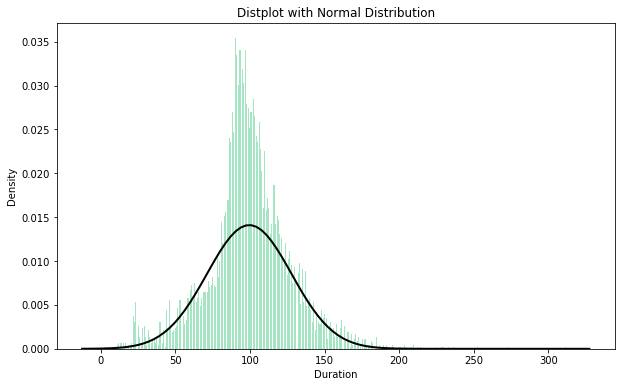

In [25]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Lọc giá trị hợp lệ
def to_float(x):
    try:
        return float(x)
    except:
        return np.nan

x1 = d2['duration'].map(to_float).dropna()

# Vẽ histogram
plt.figure(figsize=(10, 6))
plt.hist(x1, bins=int((x1.max() - x1.min()) / 0.7), color="#6ad49b", density=True, alpha=0.6)

# Vẽ đường cong chuẩn
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(x1), np.std(x1))
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distplot with Normal Distribution')
plt.xlabel('Duration')
plt.ylabel('Density')
plt.show()


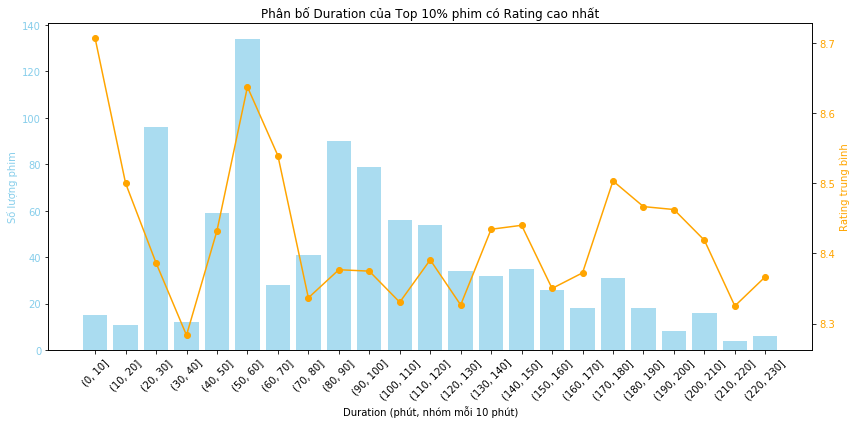

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Tiền xử lý ban đầu
df_duration_rating = imdb_rating_clean.dropna(subset=['duration', 'imdb_rating']).copy()
df_duration_rating = df_duration_rating[df_duration_rating['duration'] > 0]

# --- PHƯƠNG PHÁP 1: Lọc phim có Rating > 8.0 ---
threshold_rating = 8.0
df_top_thresh = df_duration_rating[df_duration_rating['imdb_rating'] >= threshold_rating].copy()

# --- PHƯƠNG PHÁP 2: Lọc Top 10% phim có rating cao nhất ---
top_10_percent_threshold = df_duration_rating['imdb_rating'].quantile(0.90)
df_top_10pct = df_duration_rating[df_duration_rating['imdb_rating'] >= top_10_percent_threshold].copy()

# Hàm vẽ biểu đồ cho mỗi phương pháp
def plot_duration_rating_overlay(df_subset, title):
    duration_bins = range(0, 240, 10)
    df_subset['duration_bin'] = pd.cut(df_subset['duration'], bins=duration_bins)

    rating_by_duration = df_subset.groupby('duration_bin')['imdb_rating'].mean()
    count_by_duration = df_subset['duration_bin'].value_counts().sort_index()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Histogram số lượng phim
    ax1.bar(count_by_duration.index.astype(str), count_by_duration.values, color='skyblue', alpha=0.7)
    ax1.set_ylabel('Số lượng phim', color='skyblue')
    ax1.set_xlabel('Duration (phút, nhóm mỗi 10 phút)')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    plt.xticks(rotation=45)

    # Đường rating trung bình overlay
    ax2 = ax1.twinx()
    ax2.plot(rating_by_duration.index.astype(str), rating_by_duration.values, color='orange', marker='o')
    ax2.set_ylabel('Rating trung bình', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ cho từng trường hợp
plot_duration_rating_overlay(df_top_10pct, 'Phân bố Duration của Top 10% phim có Rating cao nhất')


In [27]:
def analyze_runtime_vs_viewing(df):
    """
    Phân tích mối quan hệ giữa Runtime và Hours Viewed từ top 10% phim được xem nhiều nhất,
    loại bỏ các duration ngoại lai bằng cách giữ lại 95% dữ liệu trung tâm.
    
    Tham số:
        df: DataFrame chứa 2 cột ['Hours Viewed', 'Runtime'].
    """

    df = df.copy()

    # Loại bỏ dấu phẩy và chuyển sang số nguyên
    df['Hours Viewed'] = df['Hours Viewed'].str.replace(',', '', regex=False).astype(float)

    # Bỏ hàng thiếu giá trị hoặc định dạng sai ở Runtime
    df = df.dropna(subset=['Hours Viewed', 'Runtime'])
    df = df[df['Runtime'].str.contains(":")]

    # Chuyển đổi Runtime sang phút
    def convert_to_minutes(time_str):
        try:
            h, m = map(int, time_str.split(":"))
            return h * 60 + m
        except:
            return None

    df['Runtime_minutes'] = df['Runtime'].apply(convert_to_minutes)
    df = df.dropna(subset=['Runtime_minutes'])

    # Loại bỏ duration ngoại lai theo khoảng 95% percentiles
    lower_bound = df['Runtime_minutes'].quantile(0.025)
    upper_bound = df['Runtime_minutes'].quantile(0.975)
    df = df[(df['Runtime_minutes'] >= lower_bound) & (df['Runtime_minutes'] <= upper_bound)]

    # Lọc top 10% phim có Hours Viewed cao nhất
    threshold = df['Hours Viewed'].quantile(0.90)
    df_top = df[df['Hours Viewed'] >= threshold]

    # Nhóm runtime theo từng 10 phút
    duration_bins = range(int(lower_bound // 10) * 10, int((upper_bound // 10 + 1) * 10) + 10, 10)
    df_top['runtime_bin'] = pd.cut(df_top['Runtime_minutes'], bins=duration_bins)

    # Tính số lượng phim và trung bình Hours Viewed trong mỗi nhóm thời lượng
    count_by_runtime = df_top['runtime_bin'].value_counts().sort_index()
    viewed_by_runtime = df_top.groupby('runtime_bin')['Hours Viewed'].mean()

    # Vẽ biểu đồ
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(count_by_runtime.index.astype(str), count_by_runtime.values, color='lightgreen', alpha=0.7)
    ax1.set_ylabel('Số lượng phim', color='green')
    ax1.set_xlabel('Runtime (phút, nhóm 10 phút)')
    ax1.tick_params(axis='y', labelcolor='green')
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(viewed_by_runtime.index.astype(str), viewed_by_runtime.values, color='blue', marker='o')
    ax2.set_ylabel('Hours Viewed trung bình', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Phân tích Runtime và Hours Viewed (top 10% phim được xem nhiều nhất, loại bỏ ngoại lai)')
    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



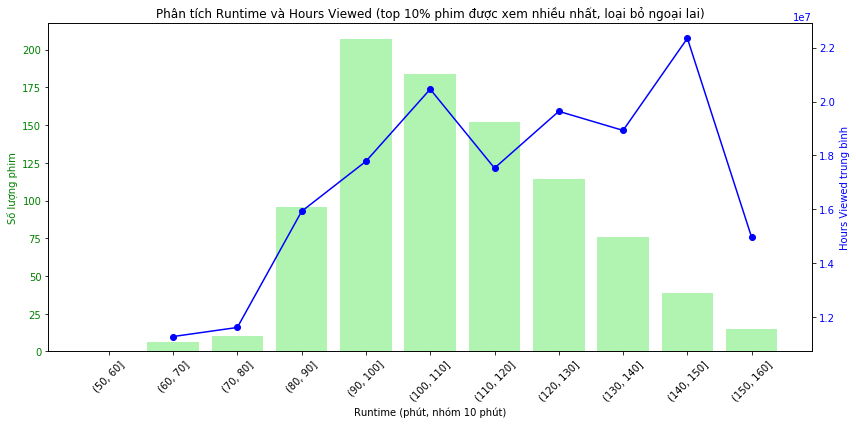

In [28]:
analyze_runtime_vs_viewing(netflix_view2_movie)

### **1. Thời lượng phổ biến và lượng xem cao nhất**

* Theo biểu đồ đầu tiên (Duration vs Hours Viewed):

  * Phim có thời lượng từ **90 đến 110 phút** chiếm số lượng lớn nhất và đạt **Hours Viewed trung bình cao nhất**.
  * Nhóm thời lượng **100-110 phút** có mức Hours Viewed rất cao (gần 2 triệu giờ xem).
  * Thời lượng trên **150 phút** chứng kiến sự sụt giảm cả về số lượng phim lẫn lượng xem.

⟶ **Khuyến nghị**: Nếu mục tiêu là **tối đa hóa lượt xem**, nên sản xuất phim có thời lượng nằm trong khoảng **90-110 phút**.

---

### **2. Phim được đánh giá cao nhất có thời lượng thế nào?**

* Theo biểu đồ thứ hai (Duration vs Rating):

  * Nhóm thời lượng **50-60 phút** có số lượng phim cao nhất **và rating trung bình rất tốt (\~8.6)**.
  * Các nhóm **trên 90 phút** vẫn giữ được mức rating ổn định quanh **8.4–8.5**.
  * Nhóm **0-10 phút** tuy có rating cao nhất (\~8.7) nhưng số lượng rất ít, có thể là phim ngắn hoặc đặc biệt, không đại diện cho đa số.

⟶ **Khuyến nghị**: Nếu mục tiêu là **đạt được rating cao**, thì thời lượng **50-90 phút** là vùng an toàn, đặc biệt khoảng **50-60 phút** có thể là lựa chọn tối ưu.


## 7. TV Shows with many seasons 

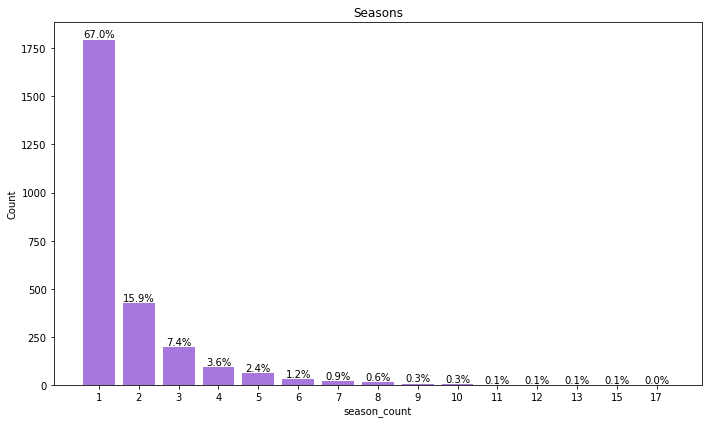

In [29]:
col = 'season_count'
vc1 = d1[col].value_counts().reset_index()
vc1 = vc1.rename(columns={col: "count", "index": col})
vc1['percent'] = vc1['count'].apply(lambda x: 100 * x / sum(vc1['count']))

vc1[col] = vc1[col].astype(int)
vc1 = vc1.sort_values(col)

plt.figure(figsize=(10, 6))
bars = plt.bar(vc1[col].astype(str), vc1["count"], color="#a678de") 

plt.title("Seasons")
plt.xlabel(col)
plt.ylabel('Count')


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f'{vc1["percent"].iloc[i]:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


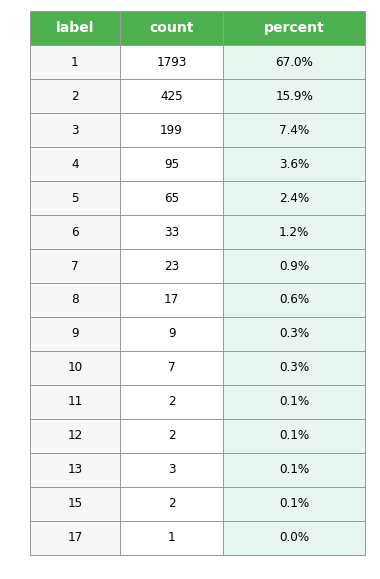

Seasons Count Summary
------------------------------
Season: 1, Count: 1793, Percent: 67.0%
Season: 2, Count: 425, Percent: 15.9%
Season: 3, Count: 199, Percent: 7.4%
Season: 4, Count: 95, Percent: 3.6%
Season: 5, Count: 65, Percent: 2.4%
Season: 6, Count: 33, Percent: 1.2%
Season: 7, Count: 23, Percent: 0.9%
Season: 8, Count: 17, Percent: 0.6%
Season: 9, Count: 9, Percent: 0.3%
Season: 10, Count: 7, Percent: 0.3%
Season: 11, Count: 2, Percent: 0.1%
Season: 12, Count: 2, Percent: 0.1%
Season: 13, Count: 3, Percent: 0.1%
Season: 15, Count: 2, Percent: 0.1%
Season: 17, Count: 1, Percent: 0.0%


In [30]:
# Loại bỏ ký tự '%' và chuyển về kiểu float
vc1['percent'] = vc1['percent'].replace('%', '', regex=True).astype(float)
vc1['percent'] = vc1['percent'].apply(lambda x: f'{x:.1f}%')

vc1 = vc1.rename(columns={col: "label"})
table_data = vc1[['label', 'count', 'percent']]

fig, ax = plt.subplots(figsize=(6, len(table_data) * 0.6 + 1))  # Điều chỉnh kích thước để bảng không bị quá nhỏ
ax.axis('off')  # Ẩn trục

# Tạo bảng
table = ax.table(cellText=table_data.values,
                 colLabels=table_data.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Tùy chỉnh bảng
table.auto_set_font_size(False) 
table.set_fontsize(12) 

for (i, j), cell in table.get_celld().items():
    if i == 0:  # Tiêu đề cột
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4CAF50')  # Màu nền tiêu đề
    else:
        cell.set_fontsize(12)
        cell.set_text_props(weight='normal', color='black')
        if j == 0:  # Cột label
            cell.set_facecolor('#f7f7f7') 
        elif j == 1:  # Cột count
            cell.set_facecolor('#ffffff') 
        elif j == 2:  # Cột percent
            cell.set_facecolor('#e7f7f0')
table.auto_set_column_width([0, 1, 2])
table.scale(1, 1.5)

for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('#999999') 
    cell.set_linewidth(1) 

plt.show()


# In số liệu đơn giản
print("Seasons Count Summary")
print("-" * 30)

# Lặp qua bảng và in từng dòng
for index, row in table_data.iterrows():
    print(f"Season: {row['label']}, Count: {row['count']}, Percent: {row['percent']}")

### TV Shows với Nhiều Mùa

Dữ liệu phản ánh sự phân bố các chương trình truyền hình theo số lượng mùa. Một phần lớn các chương trình (67%) chỉ có một mùa, với sự suy giảm mạnh khi số lượng mùa tăng lên.

#### Những điểm nổi bật:
- 67% các chương trình truyền hình chỉ có một mùa, cho thấy tỷ lệ hủy bỏ cao hoặc các chương trình không đạt được kỳ vọng của khán giả.
- Các chương trình có nhiều mùa giảm nhanh về số lượng. Đến Mùa 10, chỉ còn 0,3% chương trình
- Chỉ có 0,1% chương trình đạt 13 mùa hoặc hơn

#### Hành vi và xu hướng người xem:
- Khi chương trình kéo dài, đặc biệt là sau vài mùa, sự quan tâm của người xem giảm, dẫn đến ít chương trình kéo dài.
- Dịch vụ streaming và sự phong phú của các chương trình mới khiến người xem thiên về những chương trình mới mẻ thay vì những chương trình dài kỳ.
- Chỉ một số ít chương trình nổi bật có thể kéo dài qua 10 mùa nhờ vào cơ sở người hâm mộ vững mạnh và sự liên quan văn hóa.

#### Nguyên nhân:
- Việc duy trì nhiều mùa đòi hỏi ngân sách lớn và các khoản đầu tư liên tục, điều này có thể không bền vững.
-  Nhiều chương trình cạn kiệt ý tưởng mới theo thời gian, khiến việc giữ chân người xem trở nên khó khăn.



## 8. The ratings of the content ? 

In [31]:
print(vc1.columns)
print(vc2.columns)


Index(['label', 'count', 'percent'], dtype='object')
Index(['release_year', 'count', 'percent'], dtype='object')


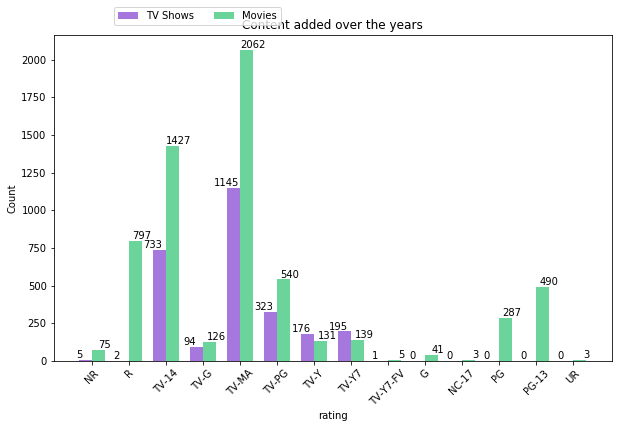

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử d1 và d2 là các DataFrame đã có sẵn
col = "rating"

# Loại bỏ các giá trị chứa "min" trong cột rating
d1_filtered = d1[~d1[col].str.contains("min", na=False)]
d2_filtered = d2[~d2[col].str.contains("min", na=False)]

# Tạo bảng tần suất cho dữ liệu d1 đã lọc
vc1 = d1_filtered[col].value_counts().reset_index()
vc1 = vc1.rename(columns={col: "count", "index": col})
vc1['percent'] = vc1['count'].apply(lambda x: 100 * x / sum(vc1['count']))
vc1 = vc1.sort_values(col)

# Tạo bảng tần suất cho dữ liệu d2 đã lọc
vc2 = d2_filtered[col].value_counts().reset_index()
vc2 = vc2.rename(columns={col: "count", "index": col})
vc2['percent'] = vc2['count'].apply(lambda x: 100 * x / sum(vc2['count']))
vc2 = vc2.sort_values(col)

# Kết hợp vc1 và vc2 thành một DataFrame để đảm bảo cùng số lượng giá trị
combined = pd.merge(vc1, vc2, on=col, how='outer', suffixes=('_tv', '_movies')).fillna(0)

# Tạo biểu đồ
fig, ax1 = plt.subplots(figsize=(10, 6))

# Biểu đồ
bar_width = 0.35
index = range(len(combined))

ax1.bar(index, combined['count_tv'], bar_width, label="TV Shows", color="#a678de")
ax1.bar([i + bar_width for i in index], combined['count_movies'], bar_width, label="Movies", color="#6ad49b")

# Thêm số liệu vào từng cột
for i, v in enumerate(combined['count_tv']):
    ax1.text(i - bar_width / 2, v + 0.5, str(int(v)), ha='center', va='bottom', fontsize=10, color='black')

for i, v in enumerate(combined['count_movies']):
    ax1.text(i + bar_width * 1.5, v + 0.5, str(int(v)), ha='center', va='bottom', fontsize=10, color='black')

# Thiết lập các chi tiết cho biểu đồ
ax1.set_xlabel(col)
ax1.set_ylabel("Count")
ax1.set_title("Content added over the years")
ax1.set_xticks([i + bar_width / 2 for i in index])
ax1.set_xticklabels(combined[col], rotation=45)
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.1), ncol=2)

plt.show()


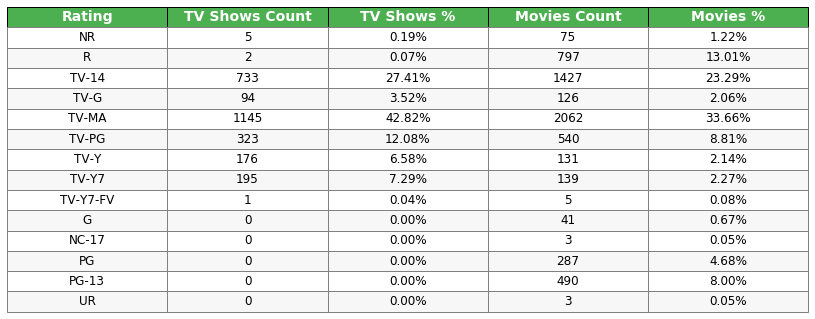

Rating: NR, TV Shows Count: 5, TV Shows %: 0.19%, Movies Count: 75, Movies %: 1.22%
Rating: R, TV Shows Count: 2, TV Shows %: 0.07%, Movies Count: 797, Movies %: 13.01%
Rating: TV-14, TV Shows Count: 733, TV Shows %: 27.41%, Movies Count: 1427, Movies %: 23.29%
Rating: TV-G, TV Shows Count: 94, TV Shows %: 3.52%, Movies Count: 126, Movies %: 2.06%
Rating: TV-MA, TV Shows Count: 1145, TV Shows %: 42.82%, Movies Count: 2062, Movies %: 33.66%
Rating: TV-PG, TV Shows Count: 323, TV Shows %: 12.08%, Movies Count: 540, Movies %: 8.81%
Rating: TV-Y, TV Shows Count: 176, TV Shows %: 6.58%, Movies Count: 131, Movies %: 2.14%
Rating: TV-Y7, TV Shows Count: 195, TV Shows %: 7.29%, Movies Count: 139, Movies %: 2.27%
Rating: TV-Y7-FV, TV Shows Count: 1, TV Shows %: 0.04%, Movies Count: 5, Movies %: 0.08%
Rating: G, TV Shows Count: 0, TV Shows %: 0.00%, Movies Count: 41, Movies %: 0.67%
Rating: NC-17, TV Shows Count: 0, TV Shows %: 0.00%, Movies Count: 3, Movies %: 0.05%
Rating: PG, TV Shows Count: 

In [33]:

fig, ax2 = plt.subplots(figsize=(10, 4))

cell_text = []
for row in combined.itertuples():
    cell_text.append([row.rating, int(row.count_tv), f"{row.percent_tv:.2f}%", int(row.count_movies), f"{row.percent_movies:.2f}%"])

# Tạo bảng
table = ax2.table(cellText=cell_text, 
                  colLabels=['Rating', 'TV Shows Count', 'TV Shows %', 'Movies Count', 'Movies %'],
                  loc='center', 
                  cellLoc='center', 
                  colColours=["#4CAF50", "#4CAF50", "#4CAF50", "#4CAF50", "#4CAF50"],  # Màu nền của các tiêu đề cột
                  cellColours=[["#ffffff", "#f0f0f0", "#ffffff", "#f0f0f0", "#ffffff"]] * len(cell_text))  # Màu nền xen kẽ cho các hàng

table.auto_set_font_size(False)  
table.set_fontsize(12)  
table.scale(1.2, 1.5)  

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  
        cell.set_facecolor("#4CAF50") 
        cell.set_edgecolor('black') 
        cell.set_text_props(color="white") 
    else:
        cell.set_edgecolor('gray')  # Viền các ô
        cell.set_facecolor('#f7f7f7' if i % 2 == 0 else '#ffffff') 
        cell.set_text_props(color='black') 

ax2.axis('off')

plt.tight_layout()
plt.show()

# In bảng số liệu đơn giản
for row in combined.itertuples():
    print(f"Rating: {row.rating}, TV Shows Count: {int(row.count_tv)}, TV Shows %: {row.percent_tv:.2f}%, "
          f"Movies Count: {int(row.count_movies)}, Movies %: {row.percent_movies:.2f}%")

### Kết luận

1. **Tăng trưởng của nội dung trưởng thành:**
   - TV-MA chiếm 42.82% trong TV Shows và 33.66% trong Movies.
   - TV-14 chiếm 27.41% trong TV Shows và 23.29% trong Movies.
   
   --> Nội dung trưởng thành đang chiếm ưu thế rõ rệt và được ưa chuộng.

2. **Thanh thiếu niên là đối tượng chủ yếu**:
   - TV-14 có tỷ lệ 27.41% trong TV Shows và 23.29% trong Movies.
   
   --> Nội dung dành cho thanh thiếu niên rất phổ biến và chiếm lĩnh thị trường.

3. **Phim trưởng thành ngày càng phổ biến**:
   - R có tỷ lệ 0.07% trong TV Shows nhưng 13.01% trong Movies.
   
   --> Phim R-rated đang ngày càng được khán giả đón nhận, đặc biệt trong ngành điện ảnh.

4. **Nội dung gia đình và trẻ em ít phổ biến**:
   - TV-G có tỷ lệ 3.52% trong TV Shows và 2.06% trong Movies.
   - TV-Y có tỷ lệ 6.58% trong TV Shows và 2.14% trong Movies.
   - TV-Y7 có tỷ lệ 7.29% trong TV Shows và 2.27% trong Movies.
   
   --> Nội dung dành cho trẻ em và gia đình ít được quan tâm, thể hiện qua tỷ lệ thấp trong TV Shows và Movies.

5. Cần nhắm đến đối tượng trưởng thành:
   - TV-MA và TV-14 chiếm tổng cộng 70.23% trong TV Shows và 56.95% trong Movies.
   
   --> Để thành công, các nhà sản xuất nội dung nên tập trung vào đối tượng trưởng thành và thanh thiếu niên, bởi đây là nhóm khán giả chủ yếu.

---

### Tóm tắt:
- **Khán giả hiện nay đang ưa chuộng nội dung trưởng thành và thanh thiếu niên, với TV-MA và TV-14 chiếm ưu thế.**
- **Nội dung dành cho trẻ em và gia đình đang bị lãng quên, với tỷ lệ rất thấp.**
- **Sản xuất nội dung hướng đến đối tượng trưởng thành và thanh thiếu niên sẽ mang lại cơ hội thành công lớn.**


## 9. What are the top Categories ?

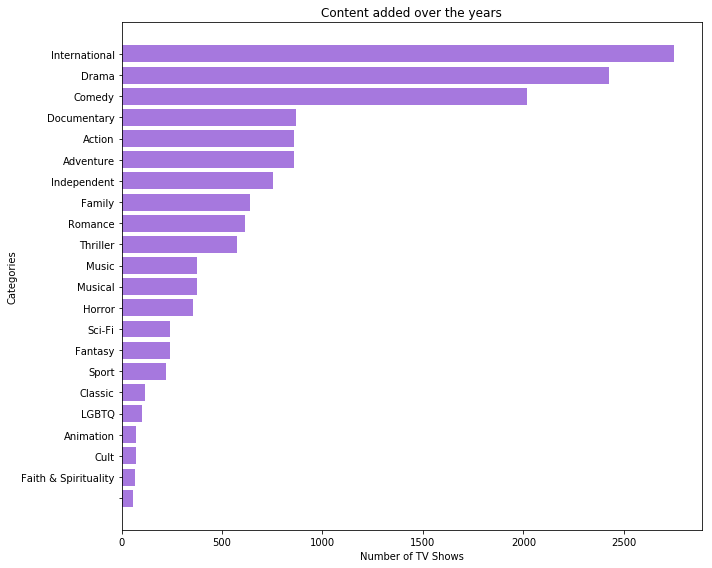

In [34]:
categories = ", ".join(d2['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)

labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]

plt.figure(figsize=(10, 8))
plt.barh(labels, values, color="#a678de")
plt.title("Content added over the years")
plt.xlabel("Number of TV Shows")
plt.ylabel("Categories")
plt.tight_layout()

plt.show()


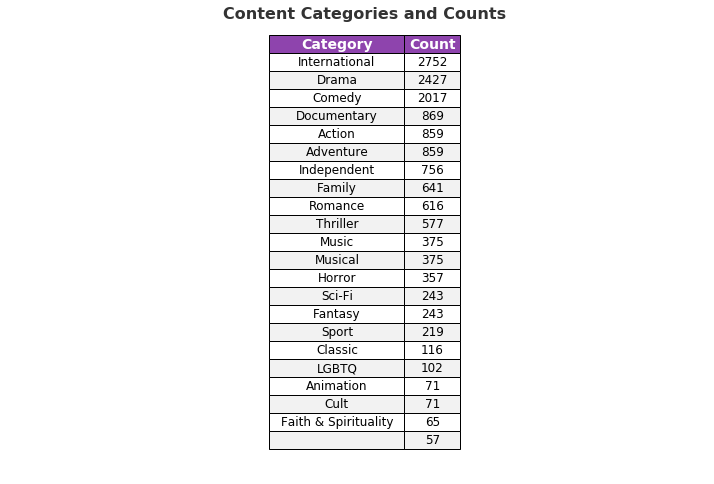

                Category  Count
0          International   2752
1                  Drama   2427
2                 Comedy   2017
3            Documentary    869
4                 Action    859
5              Adventure    859
6            Independent    756
7                 Family    641
8                Romance    616
9               Thriller    577
10                 Music    375
11               Musical    375
12                Horror    357
13                Sci-Fi    243
14               Fantasy    243
15                 Sport    219
16               Classic    116
17                 LGBTQ    102
18             Animation     71
19                  Cult     71
20  Faith & Spirituality     65
21                           57


In [35]:
categories = ", ".join(d2['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)

table_data = [[category, count] for category, count in counter_list]

fig, ax = plt.subplots(figsize=(12, 8))

ax.axis('off')

table = ax.table(cellText=table_data, colLabels=["Category", "Count"], loc='center', cellLoc='center', colColours=['#a678de']*2)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width([0, 1])  # Auto adjust column width
table.scale(1.2, 1.5)  # Scale the table to make it larger and more readable

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold', color='white')  # Header row styling
        cell.set_facecolor('#8e44ad')  # Header background color
    else:
        cell.set_fontsize(12)
        cell.set_text_props(weight='normal', color='black')
        cell.set_facecolor('#f2f2f2' if i % 2 == 0 else '#ffffff')  # Alternating row colors
    cell.set_edgecolor('black')  # Add border around cells

plt.title("Content Categories and Counts", fontsize=16, weight='bold', color='#333333')
plt.show()

categories = ", ".join(d2['listed_in']).split(", ")
counter_list = Counter(categories).most_common(50)

data = pd.DataFrame(counter_list, columns=["Category", "Count"])

print(data)

In [36]:
df_genre_rate = imdb_rating_clean.copy()
df_genre_rate['listed_in'] = df_genre_rate['listed_in'].str.split(', ')
df_genre_rate = df_genre_rate.explode('listed_in')

# Chuẩn hoá thể loại: bỏ các từ "Movie", "TV", "TV Show" và strip khoảng trắng
df_genre_rate['listed_in'] = df_genre_rate['listed_in'].str.replace(r'\b(Movie|TV|TV Shows|Movies|Shows)\b', '', regex=True)
df_genre_rate['listed_in'] = df_genre_rate['listed_in'].str.strip()

In [37]:
df_genre_rate['listed_in'].unique()

array(['Documentary', 'Animation', 'Family', 'Crime', 'Horror',
       'Thriller', 'Action', 'Sci-Fi', 'Comedy', 'Drama', 'Fantasy',
       'Mystery', 'Biography', 'Sport', 'Talk-Show', 'Music', 'Adventure',
       'Musical', 'Romance', 'Short', 'History', 'War', 'Western', nan,
       'News', 'Reality-', 'Game-Show', 'Film-Noir'], dtype=object)

Số thể loại được plot: 27
Các thể loại: ['Documentary' 'Animation' 'Family' 'Crime' 'Horror' 'Thriller' 'Action'
 'Sci-Fi' 'Comedy' 'Drama' 'Fantasy' 'Mystery' 'Biography' 'Sport'
 'Talk-Show' 'Music' 'Adventure' 'Musical' 'Romance' 'Short' 'History'
 'War' 'Western' 'News' 'Reality-' 'Game-Show' 'Film-Noir']


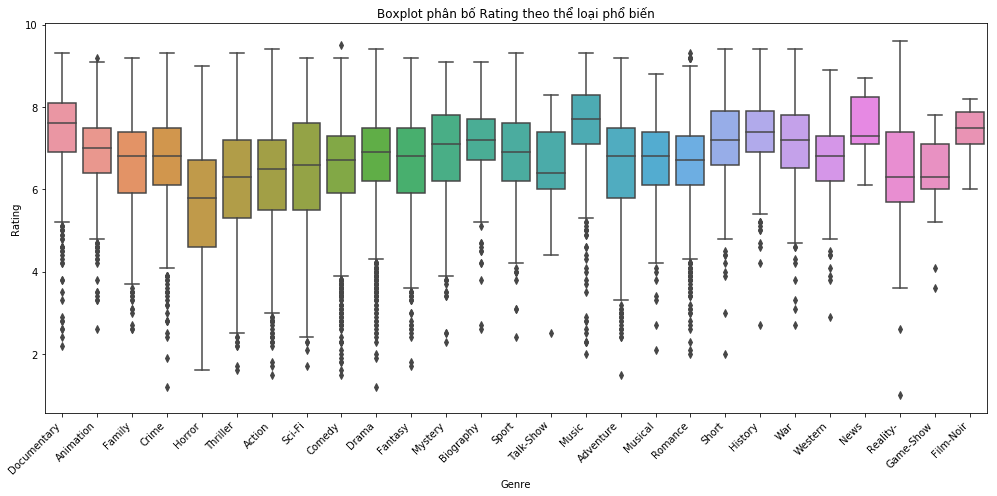

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def prepare_genre_data(df):
    """
    Chuẩn bị df từ imdb_rating_clean:
    - Tách 'listed_in' thành list,
    - explode thành từng dòng 1 thể loại,
    - loại bỏ từ khóa Movie, TV,...
    - loại bỏ thể loại rỗng nếu có.
    """
    df_copy = df.copy()
    df_copy['listed_in'] = df_copy['listed_in'].str.split(', ')
    df_copy = df_copy.explode('listed_in')

    # Chuẩn hóa tên thể loại
    df_copy['listed_in'] = df_copy['listed_in'].str.replace(r'\b(Movie|TV|TV Shows|Movies|Shows)\b', '', regex=True)
    df_copy['listed_in'] = df_copy['listed_in'].str.strip()

    # Loại bỏ dòng có thể loại rỗng (nếu có)
    df_copy = df_copy[df_copy['listed_in'] != '']
    df_copy = df_copy.dropna(subset=['listed_in'])
    
    return df_copy


def plot_selected_genres_boxplot(df, selected_genres):
    """
    Vẽ boxplot phân bố rating theo các thể loại đã chọn.
    - df: DataFrame chuẩn bị với 1 dòng 1 thể loại trong cột 'listed_in'.
    - selected_genres: list các thể loại cần lấy ra vẽ.
    """
    # Lọc df chỉ lấy thể loại trong selected_genres
    df_filtered = df[df['listed_in'].isin(selected_genres)].copy()

    # Kiểm tra số lượng thể loại trong df_filtered
    unique_genres = df_filtered['listed_in'].unique()
    print(f"Số thể loại được plot: {len(unique_genres)}")
    print(f"Các thể loại: {unique_genres}")

    # Vẽ boxplot
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='listed_in', y='imdb_rating', data=df_filtered)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Genre')
    plt.ylabel('Rating')
    plt.title('Boxplot phân bố Rating theo thể loại phổ biến')
    plt.tight_layout()
    plt.show()

# Ví dụ sử dụng:
# Bước 1: Chuẩn bị dữ liệu
df_genre_rate = prepare_genre_data(imdb_rating_clean)

# Bước 2: Định nghĩa danh sách thể loại phổ biến (bạn có thể chỉnh sửa)
popular_genres = ['Documentary', 'Animation', 'Family', 'Crime', 'Horror',
       'Thriller', 'Action', 'Sci-Fi', 'Comedy', 'Drama', 'Fantasy',
       'Mystery', 'Biography', 'Sport', 'Talk-Show', 'Music', 'Adventure',
       'Musical', 'Romance', 'Short', 'History', 'War', 'Western', 'News',
       'Reality-', 'Game-Show', 'Film-Noir']

# Bước 3: Vẽ boxplot
plot_selected_genres_boxplot(df_genre_rate, popular_genres)


### Kết quả phân tích thể loại phim

Số liệu cho thấy các thể loại phim phổ biến nhất là International Movies (2752 phim), Dramas (2427 phim), và Comedies (1674 phim), phản ánh sự yêu thích với các bộ phim đa dạng và giải trí. Các thể loại như LGBTQ Movies (102 phim) và Faith & Spirituality (65 phim) ít phổ biến hơn, nhưng vẫn cho thấy một sự quan tâm ngày càng tăng đối với các chủ đề xã hội và tinh thần.
Người xem có xu hướng ưa chuộng các thể loại giải trí, nhưng cũng quan tâm đến các vấn đề xã hội và văn hóa, mặc dù ở mức độ thấp hơn.

#### 1. Chất lượng không phụ thuộc hoàn toàn vào thể loại

* Rating trung bình của các thể loại nằm trong khoảng từ 6.5 đến 8.5.
* Không có sự khác biệt quá lớn giữa các thể loại về mặt chất lượng trung bình.
* Điều này cho thấy việc chọn thể loại không đảm bảo phim sẽ có chất lượng cao.

---

#### 2. Những thể loại tiềm năng: rating cao nhưng số lượng ít

* Thể loại "Music" có rating trung bình cao, nhưng số lượng nội dung còn rất ít.
* "Mystery" là thể loại có rating khá cao và chưa bị bão hòa.
* "Biography" thường nhận được đánh giá tích cực nhưng chưa được sản xuất nhiều.
* "Musical" cũng là thể loại có tiềm năng nhờ yếu tố giải trí, mặc dù hiện tại ít được đầu tư.
* Đây là những thể loại có khả năng tạo ra sản phẩm nổi bật do chưa có nhiều đối thủ cạnh tranh.

---

#### 3. Những thể loại phổ biến nhưng dễ bão hòa

* Thể loại "Drama" có số lượng nội dung rất lớn, dẫn đến sự cạnh tranh cao.
* "Comedy" là thể loại được sản xuất rất nhiều, nhưng rating trung bình không quá nổi bật.
* "Action" có rating tương đối thấp dù là thể loại phổ biến.
* Nếu lựa chọn các thể loại này, cần có ý tưởng thực sự sáng tạo để không bị chìm giữa đám đông.


#### Bài học
1. Tạo ra các bộ phim đa dạng, từ quốc tế đến các thể loại khác nhau để thu hút khán giả rộng rãi.
2. Theo dõi và sản xuất các bộ phim liên quan đến những chủ đề xã hội mới mẻ như LGBTQ và tôn giáo, giúp kết nối với nhóm người xem đặc thù.
3. Đảm bảo rằng các thể loại giải trí như hài, hành động luôn có chất lượng cao để duy trì sự thu hút lớn từ khán giả.
4. Nếu muốn tạo sự khác biệt, nên tập trung vào các thể loại ít phổ biến nhưng có rating cao như "Music", "Mystery", "Biography", "Musical".
5. Nếu muốn hướng tới số đông, có thể chọn "Drama", "Comedy" hoặc "Action", nhưng cần nội dung sáng tạo vượt trội.



## 10. Top Actors on Netflix with Most Movies

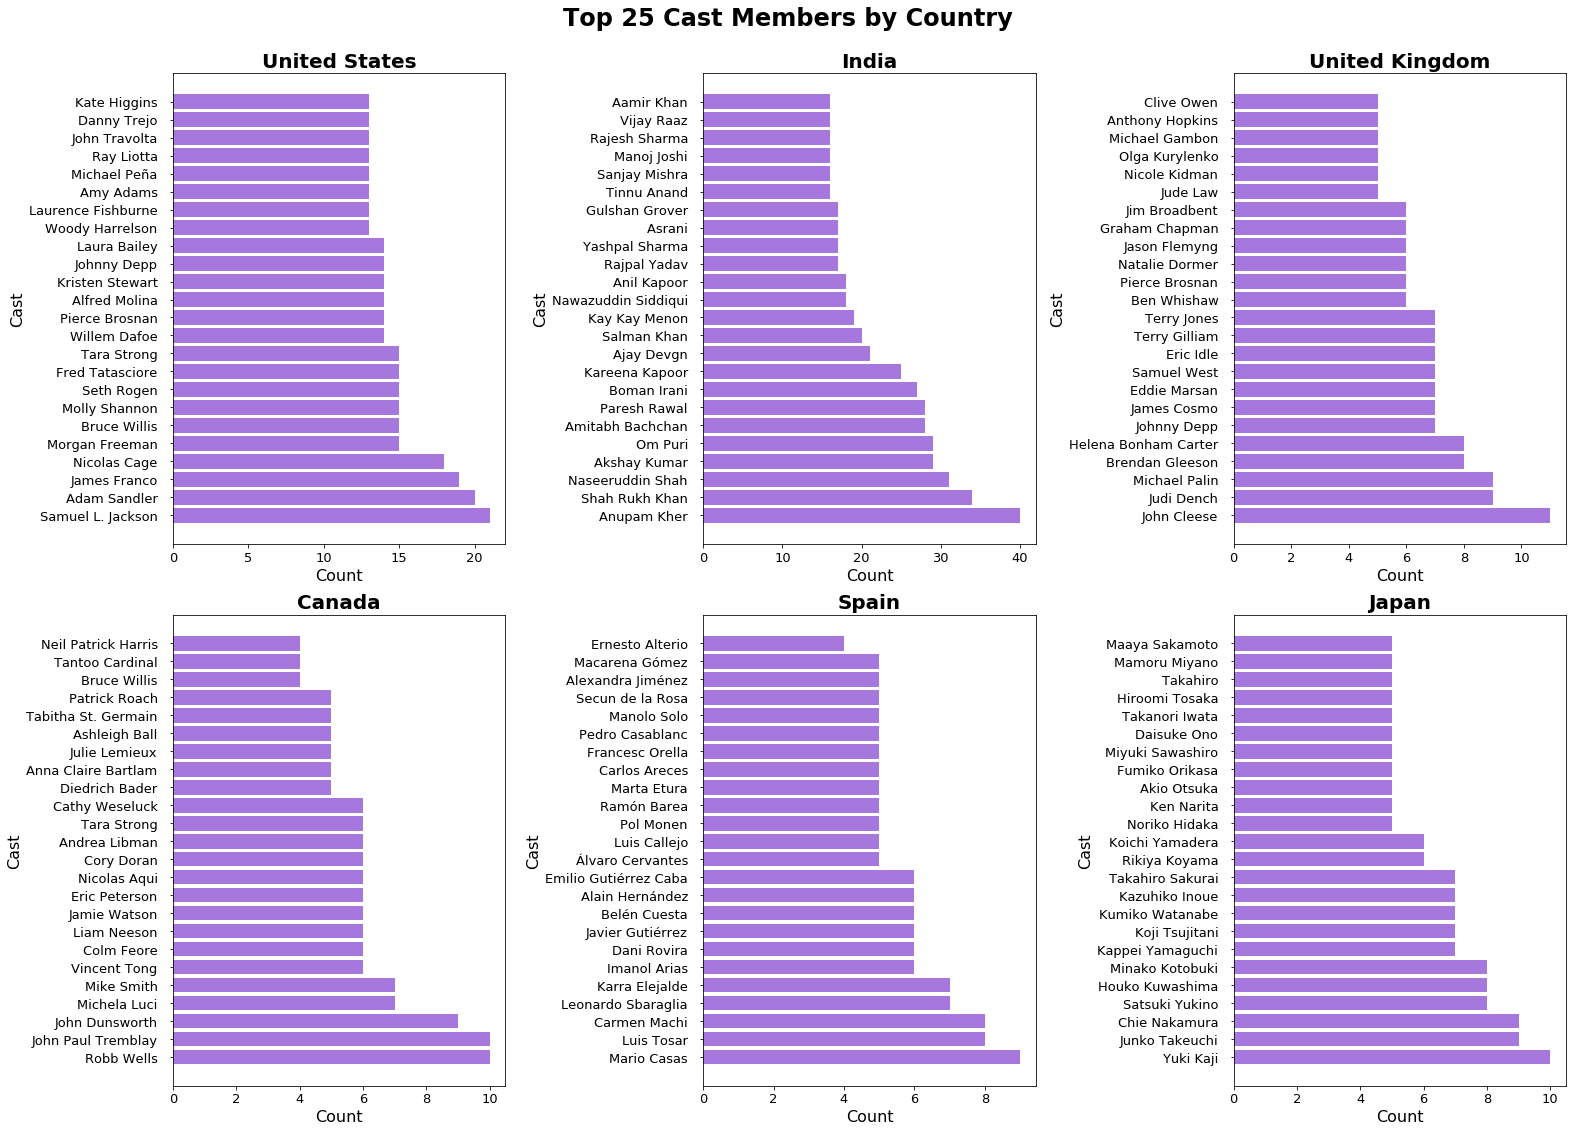

In [39]:
import math

def country_trace(country, flag="movie"):
    df["from_us"] = df['country'].fillna("").apply(lambda x: 1 if country.lower() in x.lower() else 0)
    small = df[df["from_us"] == 1]
    if flag == "movie":
        small = small[small["duration"] != ""]
    else:
        small = small[small["season_count"] != ""]
    cast = ", ".join(small['cast'].fillna("")).split(", ")
    tags = Counter(cast).most_common(25)
    tags = [tag for tag in tags if tag[0] != ""]
    labels = [tag[0] + "  " for tag in tags]
    values = [tag[1] for tag in tags]
    return labels, values

titles = ["United States", "India", "United Kingdom", "Canada", "Spain", "Japan"]
n = len(titles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(22, 16))  # ← tăng chiều cao đáng kể
axes = axes.flatten()

for i, title in enumerate(titles):
    labels, values = country_trace(title)
    ax = axes[i]
    ax.barh(labels[::-1], values[::-1], color="#a678de")
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlabel("Count", fontsize=16)
    ax.set_ylabel("Cast", fontsize=16)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)
    ax.invert_yaxis()  # ← Cast quan trọng nhất ở trên cùng

# Ẩn subplot thừa nếu có
for j in range(len(titles), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Top 25 Cast Members by Country", fontsize=24, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


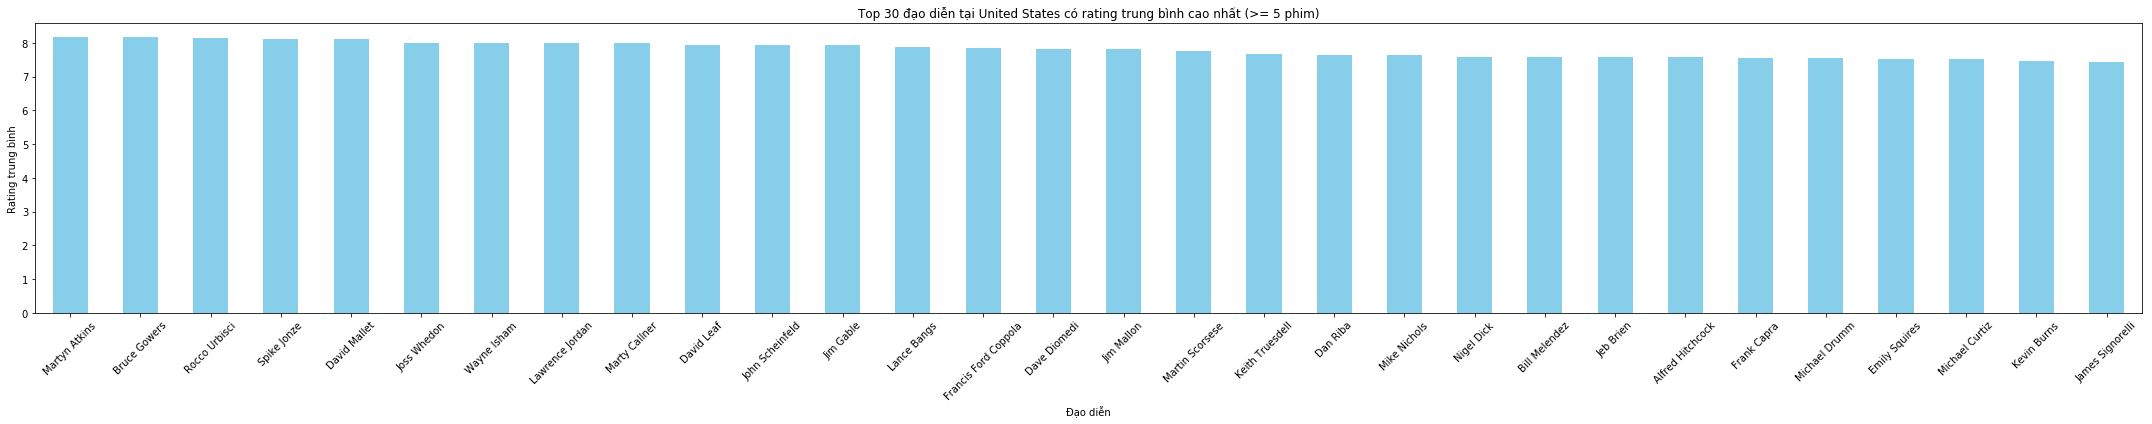

In [40]:
def plot_top_directors(df, country='United States', k=5, top_n=20):
    import matplotlib.pyplot as plt

    # Lọc theo country
    df_country = df[df['country'] == country]

    # Tách director thành list
    df_directors = df_country.assign(director=df_country['director'].str.split(', ')).explode('director')

    # Đếm số lần xuất hiện
    director_counts = df_directors['director'].value_counts()
    directors_filtered = director_counts[director_counts >= k].index

    # Lọc theo director đủ điều kiện
    filtered_df = df_directors[df_directors['director'].isin(directors_filtered)]

    # Tính rating trung bình
    director_avg_rating = (
        filtered_df.groupby('director')['imdb_rating']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
    )

    # Vẽ bar chart
    plt.figure(figsize=(30,6))
    director_avg_rating.plot(kind='bar', color='skyblue')
    plt.title(
        f'Top {top_n} đạo diễn tại {country} có rating trung bình cao nhất (>= {k} phim)'
    )
    plt.ylabel('Rating trung bình')
    plt.xlabel('Đạo diễn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_top_directors(imdb_rating_clean, country='United States', k=5, top_n=30)

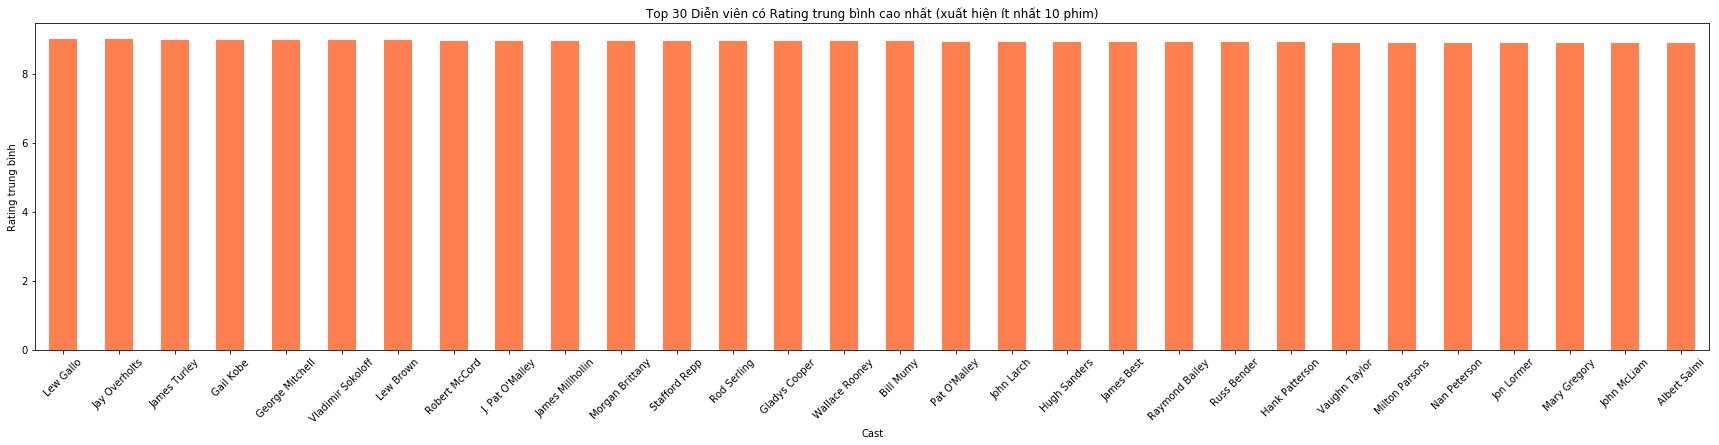

In [41]:
def plot_top_cast(df, country='United States', k=5, top_n=10):
    # Lọc theo country
    df_country = df[df['country'] == country]
    
    # Tách cast thành list
    df_cast = df_country.assign(cast=df_country['cast'].str.split(', ')).explode('cast')
    
    # Đếm số lần xuất hiện
    cast_counts = df_cast['cast'].value_counts()
    cast_filtered = cast_counts[cast_counts >= k].index
    
    # Lọc theo cast đủ điều kiện
    filtered_df = df_cast[df_cast['cast'].isin(cast_filtered)]
    
    # Tính rating trung bình
    cast_avg_rating = filtered_df.groupby('cast')['imdb_rating'].mean().sort_values(ascending=False).head(top_n)
    
    # Vẽ bar chart
    plt.figure(figsize=(30,6))
    cast_avg_rating.plot(kind='bar', color='coral')
    plt.title(f'Top {top_n} Diễn viên có Rating trung bình cao nhất (xuất hiện ít nhất {k} phim)')
    plt.ylabel('Rating trung bình')
    plt.xlabel('Cast')
    plt.xticks(rotation=45)
    plt.show()

# Gọi hàm ví dụ
plot_top_cast(imdb_rating_clean, k=10, top_n=30)


In [42]:
def create_network_graph(df, k=3, country=None):
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Nếu truyền country, lọc theo country đó
    if country is not None:
        df = df[df['country'] == country]

    # Đảm bảo các cột cần thiết không bị thiếu
    df = df.dropna(subset=['director', 'cast', 'imdb_rating'])
    df['director'] = df['director'].fillna('').astype(str)
    df['cast'] = df['cast'].fillna('').astype(str)

    # Tách director và cast để đếm số lần xuất hiện
    df_directors = df.assign(director=df['director'].str.split(', ')).explode('director')
    df_cast = df.assign(cast=df['cast'].str.split(', ')).explode('cast')

    director_counts = df_directors['director'].value_counts()
    cast_counts = df_cast['cast'].value_counts()

    # Lọc những người xuất hiện >= k lần
    directors_filtered = director_counts[director_counts >= k].index
    cast_filtered = cast_counts[cast_counts >= k].index

    G = nx.Graph()

    for idx, row in df.iterrows():
        directors_str = row['director']
        cast_str = row['cast']
        rating = row['imdb_rating']

        # Lấy tối đa 4 cast chính
        cast_main = cast_str.split(', ')[:4]

        # Giữ lại các cá nhân đủ điều kiện
        people = [d for d in directors_str.split(', ') if d in directors_filtered] + \
                 [c for c in cast_main if c in cast_filtered]

        # Tạo cạnh giữa các cá nhân trong cùng phim
        for i in range(len(people)):
            for j in range(i+1, len(people)):
                p1, p2 = people[i], people[j]
                if G.has_edge(p1, p2):
                    G[p1][p2]['weight'] = (G[p1][p2]['weight'] + rating) / 2
                else:
                    G.add_edge(p1, p2, weight=rating)

    if len(G.edges) == 0:
        print(f"Không có dữ liệu để vẽ đồ thị với country = {country} và k = {k}")
        return

    # Màu sắc theo rating
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    norm = mcolors.Normalize(vmin=weights.min(), vmax=weights.max())
    cmap = cm.viridis
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]

    # Vẽ đồ thị
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.15)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label="Rating (chuẩn hóa)")

    plt.title(
        f"Network graph (Country: {country if country else 'All'}) - Xuất hiện ≥ {k} phim"
    )
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [43]:
# create_network_graph(imdb_rating_clean, k=20, country = 'United States')

## 11. Top Actors - Director on Netflix with Most TV Shows (xét ở các nước có Movies, TV Showsphát triển)

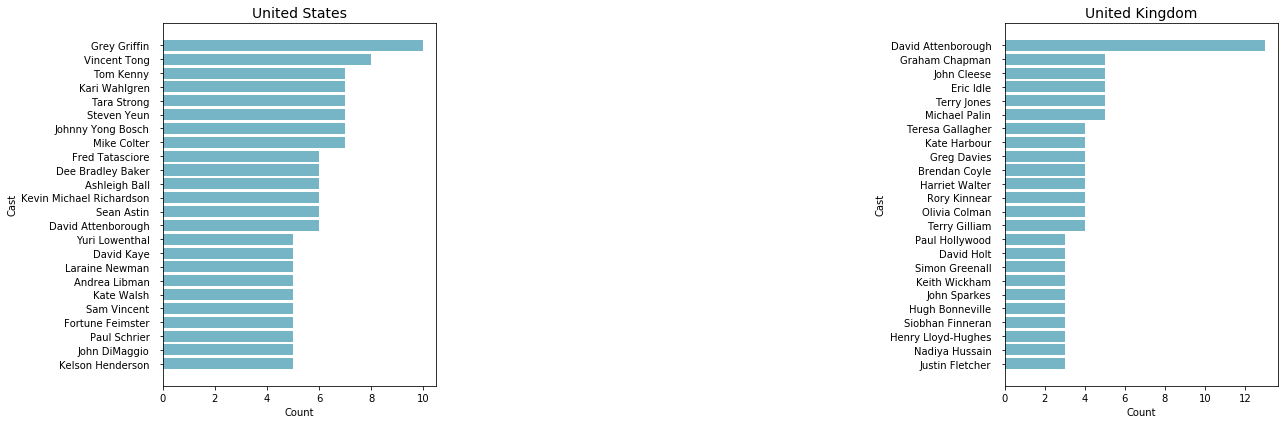

In [44]:
import matplotlib.pyplot as plt

titles = ["United States", "", "United Kingdom"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, title in enumerate(titles):
    ax = axes[i]
    if title != "":
        labels, values = country_trace(title, flag="tv_shows")
        ax.barh(labels[::-1], values[::-1], color="#76b5c5")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Count")
        ax.set_ylabel("Cast")
    else:
        ax.axis("off")

fig.tight_layout()
plt.show()


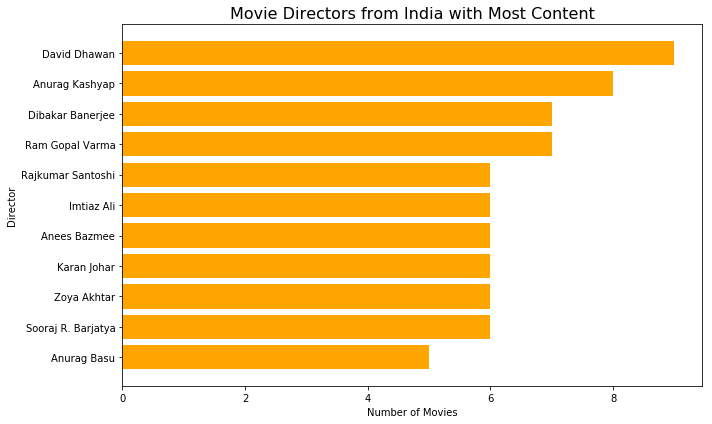

In [45]:
small = df[df["type"] == "Movie"]
small = small[small["country"] == "India"]

col = "director"
categories = ", ".join(small[col].fillna("")).split(", ")
counter_list = Counter(categories).most_common(12)
counter_list = [_ for _ in counter_list if _[0] != ""]

labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]

plt.figure(figsize=(10, 6))
plt.barh(labels, values, color="orange")
plt.title("Movie Directors from India with Most Content", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Director")
plt.tight_layout()
plt.show()


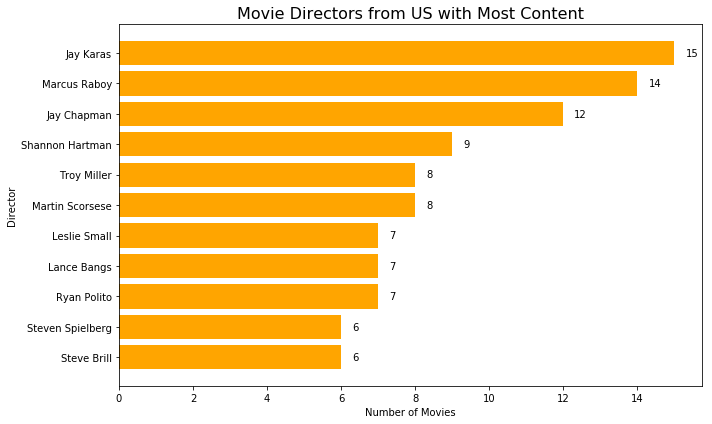

In [46]:
small = df[(df["type"] == "Movie") & (df["country"] == "United States")]

col = "director"
categories = ", ".join(small[col].fillna("")).split(", ")
counter_list = Counter(categories).most_common(12)
counter_list = [_ for _ in counter_list if _[0] != ""]

labels = [_[0] for _ in counter_list][::-1]
values = [_[1] for _ in counter_list][::-1]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color="orange")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, str(int(width)), va='center', fontsize=10)

plt.title("Movie Directors from US with Most Content", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Director")
plt.tight_layout()
plt.show()


## 12. Content Genre Trends by Year


<Figure size 1440x1152 with 0 Axes>

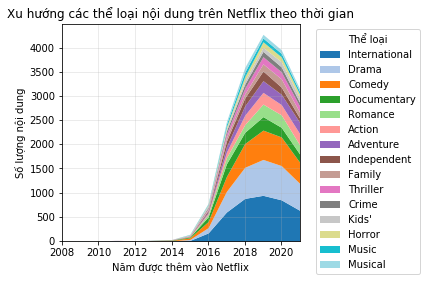

In [47]:
import matplotlib.pyplot as plt


df['listed_in'] = df['listed_in'].str.split(', ')
df = df.explode('listed_in')

df = df[df['year_added'].notna()]
df['year_added'] = df['year_added'].astype(int)

genre_by_year = df.groupby(['year_added', 'listed_in']).size().unstack(fill_value=0)

# print("Bảng số liệu các thể loại nội dung theo năm được thêm vào:")
# print(genre_by_year)

top_genres = genre_by_year.sum().sort_values(ascending=False).head(15).index

genre_by_year = genre_by_year[top_genres]

plt.figure(figsize=(20, 16))
genre_by_year.plot.area(colormap='tab20', linewidth=0)
plt.title("Xu hướng các thể loại nội dung trên Netflix theo thời gian")
plt.xlabel("Năm được thêm vào Netflix")
plt.ylabel("Số lượng nội dung")
plt.legend(title='Thể loại', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('genre_trend.png', dpi=300)
plt.show()


## **13. WordCloud**

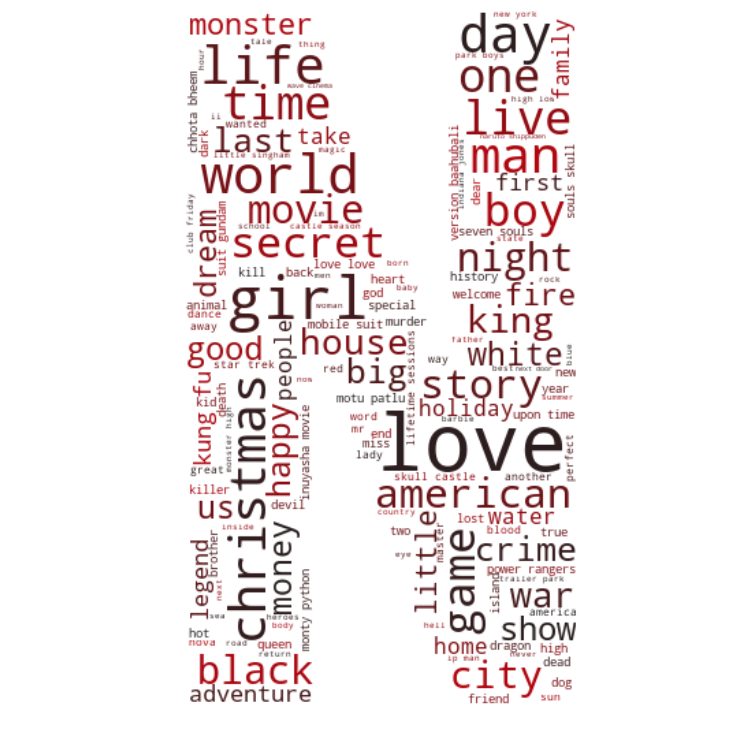

In [48]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('/kaggle/input/netflix-icon-word-cloud/732082.png'))

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, mask = mask).generate(text)

plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Từ khóa nổi bật: girl, love, game, war, king, christmas, movie, american, boy, monster, black, white

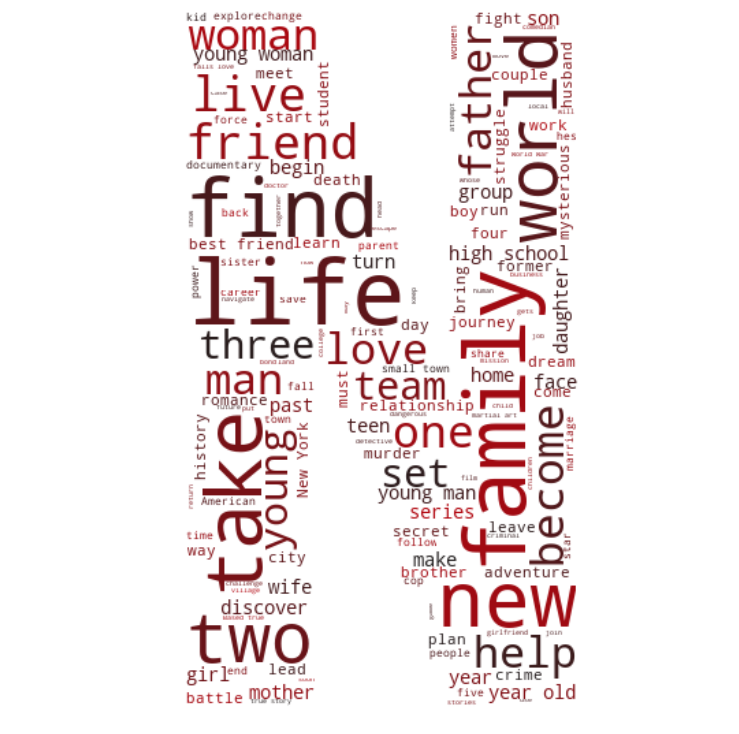

In [49]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['description'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

mask = np.array(Image.open('/kaggle/input/netflix-icon-word-cloud/732082.png'))

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150, mask = mask).generate(text)

plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Từ khóa nổi bật: family, life, new, world, friend, father, love, mother, young, daughter, son

# Xu hướng và chiến lược của Netflix

Dữ liệu nổi bật những bài học và chiến lược đã đóng góp vào thành công của Netflix:

1. Đầu tư vào đa dạng thể loại: Netflix đã mở rộng mạnh mẽ các thể loại như Action & Adventure, Anime và TV Shows. Ví dụ, Action & Adventure tăng từ 18 (2016) lên 173 (2018), trong khi Anime Series tăng từ 14 (2016) lên 42 (2019).

2. Netflix đã nhanh chóng bắt kịp các xu hướng văn hóa toàn cầu, đặc biệt là sự nổi lên của Anime và British TV Shows. Anime Series tăng từ 14 (2016) lên 42 (2019), và British TV Shows tăng từ 6 (2015) lên 48 (2017).

3. Sự tăng trưởng của TV Dramas từ 43 (2016) lên 137 (2021) cho thấy sự thành công của Netflix trong việc đầu tư vào nội dung gốc, đặc biệt là các thể loại như Crime TV Shows, Comedies, và TV Dramas.

4. Sự gia tăng của các thể loại như Sci-Fi & Fantasy, Teen TV Shows, và Thrillers cho thấy khả năng thích ứng của Netflix với sở thích đa dạng của người xem. Thriller* tăng từ 1 (2008) lên 135 (2019), phản ánh nhu cầu về các nội dung hồi hộp.

### Kết luận:
Thành công của Netflix nằm ở chiến lược đa dạng thể loại, hội nhập văn hóa toàn cầu, đầu tư vào nội dung gốc và sự hiểu biết sâu sắc về thị hiếu người xem, từ đó khẳng định vị thế dẫn đầu trong ngành giải trí toàn cầu.

